Use kernel conda_tensorflow_p36

In [2]:
import datetime as dt
import gc
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.regularizers import L1L2

plt.style.use('ggplot')

Using TensorFlow backend.


## Define helper functions

In [3]:
# Function to replace every NULL column with the mean from the training set (Naive Bayes)
def replace_nans_mean(df, split_date):
    split_idx = np.max(df.loc[df['date']<split_date].index.values)
    df_cp = df.copy()
    for col in df_cp.columns:
        if col == 'date':
            continue
        naive_estimate = df_cp.loc[:split_idx, col].mean()
        df_cp.loc[pd.isnull(df_cp[col]), col] = naive_estimate
        
    return df_cp

# Function to build 3-dimensional ndarray for LSTM based on input df and lookback window
def build_lstm_data(df, window):
    X = []
    y = []
    for i in range(len(df)-window):
        temp_set = df[i:(i+window)].copy()
        X.append(temp_set[:,1:])
        y.append(temp_set[window-1,0])

    return np.array(X), np.array(y)

## Tom Brady

In [4]:
# Read in data
brady = pd.read_csv('../data/data_final/final/features_raw/brady.csv')

# Select features for RNN, along with target. Specifically, remove averages.
features = [
    'target',
    'date',
    'player_played',
    'player_home',
    'betting_over_under_line',
    'betting_spread',
    'weather_temperature',
    'weather_wind_mph',
    'weather_humidity',
    'weather_inclement',
    'defense_fumbles_forced_moving_avg_1',
    'defense_fumbles_forced_moving_avg_3',
    'defense_fumbles_forced_moving_avg_5',
    'defense_interceptions_moving_avg_1',
    'defense_interceptions_moving_avg_3',
    'defense_interceptions_moving_avg_5',
    'defense_pass_yards_allowed_moving_avg_1',
    'defense_pass_yards_allowed_moving_avg_3',
    'defense_pass_yards_allowed_moving_avg_5',
    'defense_rush_yards_allowed_moving_avg_1',
    'defense_rush_yards_allowed_moving_avg_3',
    'defense_rush_yards_allowed_moving_avg_5',
    'defense_sacks_moving_avg_1',
    'defense_sacks_moving_avg_3',
    'defense_sacks_moving_avg_5',
    'defense_points_allowed_moving_avg_1',
    'defense_points_allowed_moving_avg_3',
    'defense_points_allowed_moving_avg_5',
    'twitter_pct_player_tweets',
    'twitter_pct_opponent_tweets',
    'twitter_count_player_swing_1_3',
    'twitter_count_opponent_swing_1_3',
    'twitter_player_net_sentiment',
    'twitter_opponent_net_sentiment',
    'twitter_player_pct_neutral',
    'twitter_opponent_pct_neutral',
    'twitter_net_sentiment_player_swing_1_3',
    'twitter_net_sentiment_opponent_swing_1_3',
    'twitter_pct_neutral_player_swing_1_3',
    'twitter_pct_neutral_opponent_swing_1_3',
]

brady = brady.loc[:, features]
brady['date'] = pd.to_datetime(brady['date'])

In [5]:
split_date = pd.Timestamp(2012,5,1)        
brady = replace_nans_mean(brady, split_date)

In [6]:
# Train + test set indices
train_idx = brady.loc[brady['date']<split_date].index.values
test_idx = brady.loc[brady['date']>split_date].index.values

# Scale Features
brady.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(brady)
brady = scaler.transform(brady)

# Train + test sets
train, test = brady[train_idx], brady[test_idx]

# Split to X and Y
# X_train, X_test, y_train, y_test = X, y = brady.iloc[:,1:], brady.iloc[:,0]

In [7]:
# Create train and test sets
window = 5
X, y = build_lstm_data(brady, window)
X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [8]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [93]:
%%time
# Build networks. Loop n times to deal with randomness.
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True, bias_regularizer=L1L2(0.01,0.01)))
    model.add(Dropout(.3))
    model.add(LSTM(30))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=250, batch_size=5, validation_data = (X_test, y_test), verbose=2, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv
        
    gc.collect()
    

Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 1s - loss: 2.2991 - val_loss: 2.1995
Epoch 2/250
 - 0s - loss: 2.3101 - val_loss: 2.1968
Epoch 3/250
 - 0s - loss: 2.2341 - val_loss: 2.1487
Epoch 4/250
 - 0s - loss: 2.1846 - val_loss: 2.1352
Epoch 5/250
 - 0s - loss: 2.1623 - val_loss: 2.1126
Epoch 6/250
 - 0s - loss: 2.1463 - val_loss: 2.1055
Epoch 7/250
 - 0s - loss: 2.1310 - val_loss: 2.0904
Epoch 8/250
 - 0s - loss: 2.0970 - val_loss: 2.0698
Epoch 9/250
 - 0s - loss: 2.0909 - val_loss: 2.0601
Epoch 10/250
 - 0s - loss: 2.0732 - val_loss: 2.0483
Epoch 11/250
 - 0s - loss: 2.0453 - val_loss: 2.0281
Epoch 12/250
 - 0s - loss: 2.0075 - val_loss: 2.0241
Epoch 13/250
 - 0s - loss: 2.0087 - val_loss: 2.0001
Epoch 14/250
 - 0s - loss: 1.9609 - val_loss: 1.9799
Epoch 15/250
 - 0s - loss: 1.9435 - val_loss: 1.9795
Epoch 16/250
 - 0s - loss: 1.9227 - val_loss: 2.0104
Epoch 17/250
 - 0s - loss: 1.8950 - val_loss: 1.9420
Epoch 18/250
 - 0s - loss: 1.8743 - val_loss: 1.9283
Epoch 19/25

Epoch 154/250
 - 0s - loss: 0.3764 - val_loss: 0.4661
Epoch 155/250
 - 0s - loss: 0.4264 - val_loss: 0.4778
Epoch 156/250
 - 0s - loss: 0.3667 - val_loss: 0.5201
Epoch 157/250
 - 0s - loss: 0.3371 - val_loss: 0.4704
Epoch 158/250
 - 0s - loss: 0.3632 - val_loss: 0.5022
Epoch 159/250
 - 0s - loss: 0.3688 - val_loss: 0.4723
Epoch 160/250
 - 0s - loss: 0.3456 - val_loss: 0.4236
Epoch 161/250
 - 0s - loss: 0.3269 - val_loss: 0.4839
Epoch 162/250
 - 0s - loss: 0.3624 - val_loss: 0.4896
Epoch 163/250
 - 0s - loss: 0.3125 - val_loss: 0.4396
Epoch 164/250
 - 0s - loss: 0.3309 - val_loss: 0.4305
Epoch 165/250
 - 0s - loss: 0.3012 - val_loss: 0.4574
Epoch 166/250
 - 0s - loss: 0.2925 - val_loss: 0.4368
Epoch 167/250
 - 0s - loss: 0.2670 - val_loss: 0.4306
Epoch 168/250
 - 0s - loss: 0.2741 - val_loss: 0.4118
Epoch 169/250
 - 0s - loss: 0.2943 - val_loss: 0.3977
Epoch 170/250
 - 0s - loss: 0.2728 - val_loss: 0.4242
Epoch 171/250
 - 0s - loss: 0.2861 - val_loss: 0.3830
Epoch 172/250
 - 0s - loss: 

 - 0s - loss: 1.3117 - val_loss: 1.3471
Epoch 57/250
 - 0s - loss: 1.2739 - val_loss: 1.3545
Epoch 58/250
 - 0s - loss: 1.2561 - val_loss: 1.3493
Epoch 59/250
 - 0s - loss: 1.2787 - val_loss: 1.3105
Epoch 60/250
 - 0s - loss: 1.2646 - val_loss: 1.2883
Epoch 61/250
 - 0s - loss: 1.2303 - val_loss: 1.3355
Epoch 62/250
 - 0s - loss: 1.2367 - val_loss: 1.3218
Epoch 63/250
 - 0s - loss: 1.2357 - val_loss: 1.2942
Epoch 64/250
 - 0s - loss: 1.1895 - val_loss: 1.2512
Epoch 65/250
 - 0s - loss: 1.1854 - val_loss: 1.2555
Epoch 66/250
 - 0s - loss: 1.1557 - val_loss: 1.2297
Epoch 67/250
 - 0s - loss: 1.1624 - val_loss: 1.2399
Epoch 68/250
 - 0s - loss: 1.1549 - val_loss: 1.2305
Epoch 69/250
 - 0s - loss: 1.1499 - val_loss: 1.1887
Epoch 70/250
 - 0s - loss: 1.1124 - val_loss: 1.2048
Epoch 71/250
 - 0s - loss: 1.1213 - val_loss: 1.1679
Epoch 72/250
 - 0s - loss: 1.0638 - val_loss: 1.2319
Epoch 73/250
 - 0s - loss: 1.0993 - val_loss: 1.2196
Epoch 74/250
 - 0s - loss: 1.1002 - val_loss: 1.1376
Epoch 

Epoch 209/250
 - 0s - loss: 0.0710 - val_loss: 0.2023
Epoch 210/250
 - 0s - loss: 0.0859 - val_loss: 0.2009
Epoch 211/250
 - 0s - loss: 0.0708 - val_loss: 0.1831
Epoch 212/250
 - 0s - loss: 0.1008 - val_loss: 0.1936
Epoch 213/250
 - 0s - loss: 0.0905 - val_loss: 0.1980
Epoch 214/250
 - 0s - loss: 0.0805 - val_loss: 0.1792
Epoch 215/250
 - 0s - loss: 0.0691 - val_loss: 0.1989
Epoch 216/250
 - 0s - loss: 0.0791 - val_loss: 0.1856
Epoch 217/250
 - 0s - loss: 0.0700 - val_loss: 0.1843
Epoch 218/250
 - 0s - loss: 0.0737 - val_loss: 0.1879
Epoch 219/250
 - 0s - loss: 0.0717 - val_loss: 0.1902
Epoch 220/250
 - 0s - loss: 0.0747 - val_loss: 0.1865
Epoch 221/250
 - 0s - loss: 0.0782 - val_loss: 0.1914
Epoch 222/250
 - 0s - loss: 0.0822 - val_loss: 0.1932
Epoch 223/250
 - 0s - loss: 0.0907 - val_loss: 0.1826
Epoch 224/250
 - 0s - loss: 0.0594 - val_loss: 0.2360
Epoch 225/250
 - 0s - loss: 0.1018 - val_loss: 0.1918
Epoch 226/250
 - 0s - loss: 0.0904 - val_loss: 0.1712
Epoch 227/250
 - 0s - loss: 

Epoch 112/250
 - 0s - loss: 0.6817 - val_loss: 0.7810
Epoch 113/250
 - 0s - loss: 0.6802 - val_loss: 0.7762
Epoch 114/250
 - 0s - loss: 0.6756 - val_loss: 0.8132
Epoch 115/250
 - 0s - loss: 0.6552 - val_loss: 0.7598
Epoch 116/250
 - 0s - loss: 0.6552 - val_loss: 0.7904
Epoch 117/250
 - 0s - loss: 0.6527 - val_loss: 0.7869
Epoch 118/250
 - 0s - loss: 0.6151 - val_loss: 0.7318
Epoch 119/250
 - 0s - loss: 0.6082 - val_loss: 0.7621
Epoch 120/250
 - 0s - loss: 0.6280 - val_loss: 0.7061
Epoch 121/250
 - 0s - loss: 0.5977 - val_loss: 0.7163
Epoch 122/250
 - 0s - loss: 0.6022 - val_loss: 0.7087
Epoch 123/250
 - 0s - loss: 0.5719 - val_loss: 0.7156
Epoch 124/250
 - 0s - loss: 0.5742 - val_loss: 0.6821
Epoch 125/250
 - 0s - loss: 0.5641 - val_loss: 0.7517
Epoch 126/250
 - 0s - loss: 0.6055 - val_loss: 0.6891
Epoch 127/250
 - 0s - loss: 0.5714 - val_loss: 0.6667
Epoch 128/250
 - 0s - loss: 0.5613 - val_loss: 0.6762
Epoch 129/250
 - 0s - loss: 0.5388 - val_loss: 0.6323
Epoch 130/250
 - 0s - loss: 

Epoch 14/250
 - 0s - loss: 2.0015 - val_loss: 2.0208
Epoch 15/250
 - 0s - loss: 1.9485 - val_loss: 1.9788
Epoch 16/250
 - 0s - loss: 1.9055 - val_loss: 2.0777
Epoch 17/250
 - 0s - loss: 1.8619 - val_loss: 2.0234
Epoch 18/250
 - 0s - loss: 1.8967 - val_loss: 1.9992
Epoch 19/250
 - 0s - loss: 1.9100 - val_loss: 1.9600
Epoch 20/250
 - 0s - loss: 1.8509 - val_loss: 2.0245
Epoch 21/250
 - 0s - loss: 1.8330 - val_loss: 1.8891
Epoch 22/250
 - 0s - loss: 1.8009 - val_loss: 1.9242
Epoch 23/250
 - 0s - loss: 1.7666 - val_loss: 2.0127
Epoch 24/250
 - 0s - loss: 1.7982 - val_loss: 1.8280
Epoch 25/250
 - 0s - loss: 1.8195 - val_loss: 1.7849
Epoch 26/250
 - 0s - loss: 1.7682 - val_loss: 1.8795
Epoch 27/250
 - 0s - loss: 1.7842 - val_loss: 1.8881
Epoch 28/250
 - 0s - loss: 1.7250 - val_loss: 1.7499
Epoch 29/250
 - 0s - loss: 1.7181 - val_loss: 1.7382
Epoch 30/250
 - 0s - loss: 1.6649 - val_loss: 1.8136
Epoch 31/250
 - 0s - loss: 1.6556 - val_loss: 1.7521
Epoch 32/250
 - 0s - loss: 1.6554 - val_loss: 

Epoch 168/250
 - 0s - loss: 0.3160 - val_loss: 0.4348
Epoch 169/250
 - 0s - loss: 0.2771 - val_loss: 0.3742
Epoch 170/250
 - 0s - loss: 0.2838 - val_loss: 0.4017
Epoch 171/250
 - 0s - loss: 0.2814 - val_loss: 0.4302
Epoch 172/250
 - 0s - loss: 0.2988 - val_loss: 0.3430
Epoch 173/250
 - 0s - loss: 0.2724 - val_loss: 0.3658
Epoch 174/250
 - 0s - loss: 0.2630 - val_loss: 0.3915
Epoch 175/250
 - 0s - loss: 0.2549 - val_loss: 0.3796
Epoch 176/250
 - 0s - loss: 0.2501 - val_loss: 0.3498
Epoch 177/250
 - 0s - loss: 0.2186 - val_loss: 0.3566
Epoch 178/250
 - 0s - loss: 0.2481 - val_loss: 0.3475
Epoch 179/250
 - 0s - loss: 0.2296 - val_loss: 0.3345
Epoch 180/250
 - 0s - loss: 0.2343 - val_loss: 0.3284
Epoch 181/250
 - 0s - loss: 0.2584 - val_loss: 0.3725
Epoch 182/250
 - 0s - loss: 0.2166 - val_loss: 0.2976
Epoch 183/250
 - 0s - loss: 0.2192 - val_loss: 0.3254
Epoch 184/250
 - 0s - loss: 0.2150 - val_loss: 0.3435
Epoch 185/250
 - 0s - loss: 0.2056 - val_loss: 0.3042
Epoch 186/250
 - 0s - loss: 

Epoch 71/250
 - 0s - loss: 1.0881 - val_loss: 1.1972
Epoch 72/250
 - 0s - loss: 1.0755 - val_loss: 1.2202
Epoch 73/250
 - 0s - loss: 1.0917 - val_loss: 1.1454
Epoch 74/250
 - 0s - loss: 1.0804 - val_loss: 1.1383
Epoch 75/250
 - 0s - loss: 1.0472 - val_loss: 1.2183
Epoch 76/250
 - 0s - loss: 1.0777 - val_loss: 1.1351
Epoch 77/250
 - 0s - loss: 1.0299 - val_loss: 1.1377
Epoch 78/250
 - 0s - loss: 1.0158 - val_loss: 1.1100
Epoch 79/250
 - 0s - loss: 0.9942 - val_loss: 1.1167
Epoch 80/250
 - 0s - loss: 0.9793 - val_loss: 1.1331
Epoch 81/250
 - 0s - loss: 0.9794 - val_loss: 1.0554
Epoch 82/250
 - 0s - loss: 0.9746 - val_loss: 1.1294
Epoch 83/250
 - 0s - loss: 0.9591 - val_loss: 1.0460
Epoch 84/250
 - 0s - loss: 0.9459 - val_loss: 1.0475
Epoch 85/250
 - 0s - loss: 0.9523 - val_loss: 1.0743
Epoch 86/250
 - 0s - loss: 0.9199 - val_loss: 1.0106
Epoch 87/250
 - 0s - loss: 0.9472 - val_loss: 1.0187
Epoch 88/250
 - 0s - loss: 0.9053 - val_loss: 1.0167
Epoch 89/250
 - 0s - loss: 0.9201 - val_loss: 

 - 0s - loss: 0.0683 - val_loss: 0.1898
Epoch 224/250
 - 0s - loss: 0.0870 - val_loss: 0.1808
Epoch 225/250
 - 0s - loss: 0.0552 - val_loss: 0.1738
Epoch 226/250
 - 0s - loss: 0.0663 - val_loss: 0.1773
Epoch 227/250
 - 0s - loss: 0.0595 - val_loss: 0.1686
Epoch 228/250
 - 0s - loss: 0.0677 - val_loss: 0.1684
Epoch 229/250
 - 0s - loss: 0.0606 - val_loss: 0.1768
Epoch 230/250
 - 0s - loss: 0.0854 - val_loss: 0.1852
Epoch 231/250
 - 0s - loss: 0.0548 - val_loss: 0.1668
Epoch 232/250
 - 0s - loss: 0.0882 - val_loss: 0.1699
Epoch 233/250
 - 0s - loss: 0.0667 - val_loss: 0.1662
Epoch 234/250
 - 0s - loss: 0.0688 - val_loss: 0.1747
Epoch 235/250
 - 0s - loss: 0.0790 - val_loss: 0.1644
Epoch 236/250
 - 0s - loss: 0.0556 - val_loss: 0.1647
Epoch 237/250
 - 0s - loss: 0.0649 - val_loss: 0.1689
Epoch 238/250
 - 0s - loss: 0.0667 - val_loss: 0.1755
Epoch 239/250
 - 0s - loss: 0.0606 - val_loss: 0.1772
Epoch 240/250
 - 0s - loss: 0.0784 - val_loss: 0.1757
Epoch 241/250
 - 0s - loss: 0.0484 - val_l

 - 0s - loss: 0.5432 - val_loss: 0.6659
Epoch 127/250
 - 0s - loss: 0.5429 - val_loss: 0.6706
Epoch 128/250
 - 0s - loss: 0.5461 - val_loss: 0.6329
Epoch 129/250
 - 0s - loss: 0.5492 - val_loss: 0.6086
Epoch 130/250
 - 0s - loss: 0.5329 - val_loss: 0.6268
Epoch 131/250
 - 0s - loss: 0.5011 - val_loss: 0.6094
Epoch 132/250
 - 0s - loss: 0.5377 - val_loss: 0.5886
Epoch 133/250
 - 0s - loss: 0.4896 - val_loss: 0.6206
Epoch 134/250
 - 0s - loss: 0.5026 - val_loss: 0.6028
Epoch 135/250
 - 0s - loss: 0.4736 - val_loss: 0.6046
Epoch 136/250
 - 0s - loss: 0.4843 - val_loss: 0.5739
Epoch 137/250
 - 0s - loss: 0.4788 - val_loss: 0.5993
Epoch 138/250
 - 0s - loss: 0.4560 - val_loss: 0.5683
Epoch 139/250
 - 0s - loss: 0.4458 - val_loss: 0.5677
Epoch 140/250
 - 0s - loss: 0.4346 - val_loss: 0.5726
Epoch 141/250
 - 0s - loss: 0.4454 - val_loss: 0.5550
Epoch 142/250
 - 0s - loss: 0.4412 - val_loss: 0.5534
Epoch 143/250
 - 0s - loss: 0.4179 - val_loss: 0.5449
Epoch 144/250
 - 0s - loss: 0.4252 - val_l

Epoch 28/250
 - 0s - loss: 1.6892 - val_loss: 1.8276
Epoch 29/250
 - 0s - loss: 1.7222 - val_loss: 1.8071
Epoch 30/250
 - 0s - loss: 1.6765 - val_loss: 1.7444
Epoch 31/250
 - 0s - loss: 1.6482 - val_loss: 1.7135
Epoch 32/250
 - 0s - loss: 1.6329 - val_loss: 1.7545
Epoch 33/250
 - 0s - loss: 1.6424 - val_loss: 1.6993
Epoch 34/250
 - 0s - loss: 1.6072 - val_loss: 1.6552
Epoch 35/250
 - 0s - loss: 1.5979 - val_loss: 1.6807
Epoch 36/250
 - 0s - loss: 1.5596 - val_loss: 1.6429
Epoch 37/250
 - 0s - loss: 1.5544 - val_loss: 1.6691
Epoch 38/250
 - 0s - loss: 1.5517 - val_loss: 1.6122
Epoch 39/250
 - 0s - loss: 1.5181 - val_loss: 1.6528
Epoch 40/250
 - 0s - loss: 1.5409 - val_loss: 1.6498
Epoch 41/250
 - 0s - loss: 1.5193 - val_loss: 1.5586
Epoch 42/250
 - 0s - loss: 1.4591 - val_loss: 1.6312
Epoch 43/250
 - 0s - loss: 1.4844 - val_loss: 1.5812
Epoch 44/250
 - 0s - loss: 1.4670 - val_loss: 1.5481
Epoch 45/250
 - 0s - loss: 1.4634 - val_loss: 1.6167
Epoch 46/250
 - 0s - loss: 1.4494 - val_loss: 

 - 0s - loss: 0.1719 - val_loss: 0.3191
Epoch 182/250
 - 0s - loss: 0.1750 - val_loss: 0.3125
Epoch 183/250
 - 0s - loss: 0.1877 - val_loss: 0.3145
Epoch 184/250
 - 0s - loss: 0.1767 - val_loss: 0.3079
Epoch 185/250
 - 0s - loss: 0.1900 - val_loss: 0.3100
Epoch 186/250
 - 0s - loss: 0.1685 - val_loss: 0.2820
Epoch 187/250
 - 0s - loss: 0.1516 - val_loss: 0.2888
Epoch 188/250
 - 0s - loss: 0.1706 - val_loss: 0.3039
Epoch 189/250
 - 0s - loss: 0.1578 - val_loss: 0.2944
Epoch 190/250
 - 0s - loss: 0.1636 - val_loss: 0.2838
Epoch 191/250
 - 0s - loss: 0.1316 - val_loss: 0.2764
Epoch 192/250
 - 0s - loss: 0.1506 - val_loss: 0.2847
Epoch 193/250
 - 0s - loss: 0.1545 - val_loss: 0.2470
Epoch 194/250
 - 0s - loss: 0.1372 - val_loss: 0.2672
Epoch 195/250
 - 0s - loss: 0.1514 - val_loss: 0.2523
Epoch 196/250
 - 0s - loss: 0.1335 - val_loss: 0.2529
Epoch 197/250
 - 0s - loss: 0.1378 - val_loss: 0.2662
Epoch 198/250
 - 0s - loss: 0.1270 - val_loss: 0.2487
Epoch 199/250
 - 0s - loss: 0.1119 - val_l

Epoch 84/250
 - 0s - loss: 0.9672 - val_loss: 1.0350
Epoch 85/250
 - 0s - loss: 0.9615 - val_loss: 1.0947
Epoch 86/250
 - 0s - loss: 0.9667 - val_loss: 1.0433
Epoch 87/250
 - 0s - loss: 0.9357 - val_loss: 1.0154
Epoch 88/250
 - 0s - loss: 0.9135 - val_loss: 1.0404
Epoch 89/250
 - 0s - loss: 0.8837 - val_loss: 1.0336
Epoch 90/250
 - 0s - loss: 0.9033 - val_loss: 1.0339
Epoch 91/250
 - 0s - loss: 0.8889 - val_loss: 1.0126
Epoch 92/250
 - 0s - loss: 0.8585 - val_loss: 1.0485
Epoch 93/250
 - 0s - loss: 0.8757 - val_loss: 0.9763
Epoch 94/250
 - 0s - loss: 0.8876 - val_loss: 0.9959
Epoch 95/250
 - 0s - loss: 0.8504 - val_loss: 1.0181
Epoch 96/250
 - 0s - loss: 0.8294 - val_loss: 0.9283
Epoch 97/250
 - 0s - loss: 0.8324 - val_loss: 0.9476
Epoch 98/250
 - 0s - loss: 0.7810 - val_loss: 0.9521
Epoch 99/250
 - 0s - loss: 0.8104 - val_loss: 0.9272
Epoch 100/250
 - 0s - loss: 0.8011 - val_loss: 0.9151
Epoch 101/250
 - 0s - loss: 0.7938 - val_loss: 0.9243
Epoch 102/250
 - 0s - loss: 0.7832 - val_los

 - 0s - loss: 0.0707 - val_loss: 0.1830
Epoch 237/250
 - 0s - loss: 0.0843 - val_loss: 0.1722
Epoch 238/250
 - 0s - loss: 0.0556 - val_loss: 0.1928
Epoch 239/250
 - 0s - loss: 0.0703 - val_loss: 0.1999
Epoch 240/250
 - 0s - loss: 0.0607 - val_loss: 0.1772
Epoch 241/250
 - 0s - loss: 0.0767 - val_loss: 0.2148
Epoch 242/250
 - 0s - loss: 0.1139 - val_loss: 0.2061
Epoch 243/250
 - 0s - loss: 0.0729 - val_loss: 0.1756
Epoch 244/250
 - 0s - loss: 0.0697 - val_loss: 0.1944
Epoch 245/250
 - 0s - loss: 0.0518 - val_loss: 0.2018
Epoch 246/250
 - 0s - loss: 0.0427 - val_loss: 0.2102
Epoch 247/250
 - 0s - loss: 0.0841 - val_loss: 0.1875
Epoch 248/250
 - 0s - loss: 0.0809 - val_loss: 0.1924
Epoch 249/250
 - 0s - loss: 0.0774 - val_loss: 0.2225
Epoch 250/250
 - 0s - loss: 0.0872 - val_loss: 0.1907
Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 1s - loss: 2.2980 - val_loss: 2.2013
Epoch 2/250
 - 0s - loss: 2.2142 - val_loss: 2.2164
Epoch 3/250
 - 0s - loss: 2.2101 - val_loss: 2.1668
Epoc

 - 0s - loss: 0.4683 - val_loss: 0.5666
Epoch 140/250
 - 0s - loss: 0.4533 - val_loss: 0.5832
Epoch 141/250
 - 0s - loss: 0.4570 - val_loss: 0.5902
Epoch 142/250
 - 0s - loss: 0.4291 - val_loss: 0.5743
Epoch 143/250
 - 0s - loss: 0.4529 - val_loss: 0.5560
Epoch 144/250
 - 0s - loss: 0.4300 - val_loss: 0.6050
Epoch 145/250
 - 0s - loss: 0.4383 - val_loss: 0.5193
Epoch 146/250
 - 0s - loss: 0.4617 - val_loss: 0.5149
Epoch 147/250
 - 0s - loss: 0.4176 - val_loss: 0.5247
Epoch 148/250
 - 0s - loss: 0.4018 - val_loss: 0.5203
Epoch 149/250
 - 0s - loss: 0.3895 - val_loss: 0.5037
Epoch 150/250
 - 0s - loss: 0.3893 - val_loss: 0.5116
Epoch 151/250
 - 0s - loss: 0.3741 - val_loss: 0.5099
Epoch 152/250
 - 0s - loss: 0.3545 - val_loss: 0.4972
Epoch 153/250
 - 0s - loss: 0.3535 - val_loss: 0.4961
Epoch 154/250
 - 0s - loss: 0.3434 - val_loss: 0.4908
Epoch 155/250
 - 0s - loss: 0.3571 - val_loss: 0.4920
Epoch 156/250
 - 0s - loss: 0.3525 - val_loss: 0.4810
Epoch 157/250
 - 0s - loss: 0.3596 - val_l

 - 0s - loss: 1.5139 - val_loss: 1.5981
Epoch 42/250
 - 0s - loss: 1.4964 - val_loss: 1.5713
Epoch 43/250
 - 0s - loss: 1.4550 - val_loss: 1.5709
Epoch 44/250
 - 0s - loss: 1.4433 - val_loss: 1.5293
Epoch 45/250
 - 0s - loss: 1.4404 - val_loss: 1.5547
Epoch 46/250
 - 0s - loss: 1.4405 - val_loss: 1.5029
Epoch 47/250
 - 0s - loss: 1.4219 - val_loss: 1.5064
Epoch 48/250
 - 0s - loss: 1.3856 - val_loss: 1.5099
Epoch 49/250
 - 0s - loss: 1.3794 - val_loss: 1.5904
Epoch 50/250
 - 0s - loss: 1.3544 - val_loss: 1.4134
Epoch 51/250
 - 0s - loss: 1.4667 - val_loss: 1.4011
Epoch 52/250
 - 0s - loss: 1.3605 - val_loss: 1.4594
Epoch 53/250
 - 0s - loss: 1.3365 - val_loss: 1.4087
Epoch 54/250
 - 0s - loss: 1.2985 - val_loss: 1.4104
Epoch 55/250
 - 0s - loss: 1.3034 - val_loss: 1.3834
Epoch 56/250
 - 0s - loss: 1.2997 - val_loss: 1.4032
Epoch 57/250
 - 0s - loss: 1.2796 - val_loss: 1.3778
Epoch 58/250
 - 0s - loss: 1.2706 - val_loss: 1.3842
Epoch 59/250
 - 0s - loss: 1.2408 - val_loss: 1.3182
Epoch 

 - 0s - loss: 0.1383 - val_loss: 0.2801
Epoch 195/250
 - 0s - loss: 0.1701 - val_loss: 0.2657
Epoch 196/250
 - 0s - loss: 0.1667 - val_loss: 0.2436
Epoch 197/250
 - 0s - loss: 0.1494 - val_loss: 0.2577
Epoch 198/250
 - 0s - loss: 0.1518 - val_loss: 0.2780
Epoch 199/250
 - 0s - loss: 0.1322 - val_loss: 0.2641
Epoch 200/250
 - 0s - loss: 0.1391 - val_loss: 0.2478
Epoch 201/250
 - 0s - loss: 0.1178 - val_loss: 0.2753
Epoch 202/250
 - 0s - loss: 0.1458 - val_loss: 0.2394
Epoch 203/250
 - 0s - loss: 0.1276 - val_loss: 0.2315
Epoch 204/250
 - 0s - loss: 0.1091 - val_loss: 0.2680
Epoch 205/250
 - 0s - loss: 0.1101 - val_loss: 0.2260
Epoch 206/250
 - 0s - loss: 0.1526 - val_loss: 0.2211
Epoch 207/250
 - 0s - loss: 0.0812 - val_loss: 0.2278
Epoch 208/250
 - 0s - loss: 0.0901 - val_loss: 0.2066
Epoch 209/250
 - 0s - loss: 0.1149 - val_loss: 0.2060
Epoch 210/250
 - 0s - loss: 0.0821 - val_loss: 0.2199
Epoch 211/250
 - 0s - loss: 0.0630 - val_loss: 0.1907
Epoch 212/250
 - 0s - loss: 0.0850 - val_l

 - 0s - loss: 0.8168 - val_loss: 0.9233
Epoch 98/250
 - 0s - loss: 0.8161 - val_loss: 0.9502
Epoch 99/250
 - 0s - loss: 0.8060 - val_loss: 0.8976
Epoch 100/250
 - 0s - loss: 0.7790 - val_loss: 0.8922
Epoch 101/250
 - 0s - loss: 0.7889 - val_loss: 0.9106
Epoch 102/250
 - 0s - loss: 0.7974 - val_loss: 0.8508
Epoch 103/250
 - 0s - loss: 0.8342 - val_loss: 0.8387
Epoch 104/250
 - 0s - loss: 0.7785 - val_loss: 0.9124
Epoch 105/250
 - 0s - loss: 0.7501 - val_loss: 0.8336
Epoch 106/250
 - 0s - loss: 0.7312 - val_loss: 0.8730
Epoch 107/250
 - 0s - loss: 0.7353 - val_loss: 0.8302
Epoch 108/250
 - 0s - loss: 0.7385 - val_loss: 0.8061
Epoch 109/250
 - 0s - loss: 0.6975 - val_loss: 0.8310
Epoch 110/250
 - 0s - loss: 0.7020 - val_loss: 0.8103
Epoch 111/250
 - 0s - loss: 0.7097 - val_loss: 0.7995
Epoch 112/250
 - 0s - loss: 0.6882 - val_loss: 0.7876
Epoch 113/250
 - 0s - loss: 0.6734 - val_loss: 0.7879
Epoch 114/250
 - 0s - loss: 0.6759 - val_loss: 0.7505
Epoch 115/250
 - 0s - loss: 0.6531 - val_los

 - 0s - loss: 0.0595 - val_loss: 0.2022
Epoch 250/250
 - 0s - loss: 0.0488 - val_loss: 0.1933
Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 1s - loss: 2.2601 - val_loss: 2.1967
Epoch 2/250
 - 0s - loss: 2.2163 - val_loss: 2.1924
Epoch 3/250
 - 0s - loss: 2.2561 - val_loss: 2.1822
Epoch 4/250
 - 0s - loss: 2.1852 - val_loss: 2.1523
Epoch 5/250
 - 0s - loss: 2.1279 - val_loss: 2.1343
Epoch 6/250
 - 0s - loss: 2.1464 - val_loss: 2.1257
Epoch 7/250
 - 0s - loss: 2.1053 - val_loss: 2.1041
Epoch 8/250
 - 0s - loss: 2.0722 - val_loss: 2.1076
Epoch 9/250
 - 0s - loss: 2.0637 - val_loss: 2.0954
Epoch 10/250
 - 0s - loss: 2.0449 - val_loss: 2.0910
Epoch 11/250
 - 0s - loss: 2.0382 - val_loss: 2.0616
Epoch 12/250
 - 0s - loss: 1.9911 - val_loss: 2.1017
Epoch 13/250
 - 0s - loss: 1.9928 - val_loss: 2.1398
Epoch 14/250
 - 0s - loss: 1.9303 - val_loss: 2.0106
Epoch 15/250
 - 0s - loss: 1.9391 - val_loss: 2.1985
Epoch 16/250
 - 0s - loss: 2.0012 - val_loss: 2.0190
Epoch 17/250
 - 0s - lo

 - 0s - loss: 0.4225 - val_loss: 0.5205
Epoch 153/250
 - 0s - loss: 0.3862 - val_loss: 0.5407
Epoch 154/250
 - 0s - loss: 0.3668 - val_loss: 0.4730
Epoch 155/250
 - 0s - loss: 0.3706 - val_loss: 0.4841
Epoch 156/250
 - 0s - loss: 0.3629 - val_loss: 0.4822
Epoch 157/250
 - 0s - loss: 0.3473 - val_loss: 0.4619
Epoch 158/250
 - 0s - loss: 0.3333 - val_loss: 0.4555
Epoch 159/250
 - 0s - loss: 0.3414 - val_loss: 0.4895
Epoch 160/250
 - 0s - loss: 0.3437 - val_loss: 0.4590
Epoch 161/250
 - 0s - loss: 0.3354 - val_loss: 0.4451
Epoch 162/250
 - 0s - loss: 0.3073 - val_loss: 0.4870
Epoch 163/250
 - 0s - loss: 0.3197 - val_loss: 0.4438
Epoch 164/250
 - 0s - loss: 0.3294 - val_loss: 0.4041
Epoch 165/250
 - 0s - loss: 0.3229 - val_loss: 0.4223
Epoch 166/250
 - 0s - loss: 0.2848 - val_loss: 0.4098
Epoch 167/250
 - 0s - loss: 0.2922 - val_loss: 0.3850
Epoch 168/250
 - 0s - loss: 0.2693 - val_loss: 0.4015
Epoch 169/250
 - 0s - loss: 0.2759 - val_loss: 0.4373
Epoch 170/250
 - 0s - loss: 0.2845 - val_l

Epoch 55/250
 - 0s - loss: 1.3087 - val_loss: 1.3930
Epoch 56/250
 - 0s - loss: 1.2839 - val_loss: 1.4332
Epoch 57/250
 - 0s - loss: 1.3186 - val_loss: 1.4323
Epoch 58/250
 - 0s - loss: 1.2575 - val_loss: 1.3640
Epoch 59/250
 - 0s - loss: 1.2546 - val_loss: 1.3449
Epoch 60/250
 - 0s - loss: 1.2576 - val_loss: 1.3921
Epoch 61/250
 - 0s - loss: 1.2283 - val_loss: 1.4211
Epoch 62/250
 - 0s - loss: 1.2164 - val_loss: 1.3104
Epoch 63/250
 - 0s - loss: 1.2295 - val_loss: 1.2617
Epoch 64/250
 - 0s - loss: 1.1925 - val_loss: 1.3784
Epoch 65/250
 - 0s - loss: 1.2336 - val_loss: 1.3694
Epoch 66/250
 - 0s - loss: 1.1602 - val_loss: 1.2629
Epoch 67/250
 - 0s - loss: 1.1686 - val_loss: 1.3170
Epoch 68/250
 - 0s - loss: 1.1549 - val_loss: 1.2825
Epoch 69/250
 - 0s - loss: 1.1610 - val_loss: 1.2143
Epoch 70/250
 - 0s - loss: 1.1096 - val_loss: 1.2303
Epoch 71/250
 - 0s - loss: 1.0992 - val_loss: 1.1833
Epoch 72/250
 - 0s - loss: 1.1097 - val_loss: 1.2732
Epoch 73/250
 - 0s - loss: 1.1389 - val_loss: 

Epoch 208/250
 - 0s - loss: 0.0819 - val_loss: 0.2119
Epoch 209/250
 - 0s - loss: 0.0633 - val_loss: 0.1961
Epoch 210/250
 - 0s - loss: 0.0789 - val_loss: 0.1863
Epoch 211/250
 - 0s - loss: 0.0843 - val_loss: 0.2045
Epoch 212/250
 - 0s - loss: 0.0725 - val_loss: 0.2198
Epoch 213/250
 - 0s - loss: 0.0917 - val_loss: 0.1701
Epoch 214/250
 - 0s - loss: 0.0763 - val_loss: 0.1889
Epoch 215/250
 - 0s - loss: 0.0478 - val_loss: 0.2076
Epoch 216/250
 - 0s - loss: 0.0853 - val_loss: 0.1997
Epoch 217/250
 - 0s - loss: 0.0603 - val_loss: 0.1660
Epoch 218/250
 - 0s - loss: 0.0667 - val_loss: 0.1994
Epoch 219/250
 - 0s - loss: 0.0800 - val_loss: 0.1990
Epoch 220/250
 - 0s - loss: 0.0521 - val_loss: 0.1902
Epoch 221/250
 - 0s - loss: 0.0738 - val_loss: 0.1899
Epoch 222/250
 - 0s - loss: 0.0605 - val_loss: 0.1882
Epoch 223/250
 - 0s - loss: 0.0799 - val_loss: 0.2020
Epoch 224/250
 - 0s - loss: 0.0526 - val_loss: 0.1690
Epoch 225/250
 - 0s - loss: 0.0993 - val_loss: 0.1858
Epoch 226/250
 - 0s - loss: 

Epoch 111/250
 - 0s - loss: 0.6858 - val_loss: 0.7472
Epoch 112/250
 - 0s - loss: 0.6784 - val_loss: 0.7943
Epoch 113/250
 - 0s - loss: 0.6946 - val_loss: 0.7520
Epoch 114/250
 - 0s - loss: 0.6602 - val_loss: 0.7439
Epoch 115/250
 - 0s - loss: 0.6565 - val_loss: 0.7274
Epoch 116/250
 - 0s - loss: 0.6494 - val_loss: 0.7591
Epoch 117/250
 - 0s - loss: 0.6278 - val_loss: 0.7668
Epoch 118/250
 - 0s - loss: 0.6174 - val_loss: 0.7247
Epoch 119/250
 - 0s - loss: 0.6352 - val_loss: 0.6774
Epoch 120/250
 - 0s - loss: 0.5950 - val_loss: 0.7354
Epoch 121/250
 - 0s - loss: 0.6333 - val_loss: 0.6976
Epoch 122/250
 - 0s - loss: 0.5785 - val_loss: 0.6720
Epoch 123/250
 - 0s - loss: 0.5759 - val_loss: 0.6722
Epoch 124/250
 - 0s - loss: 0.5767 - val_loss: 0.6932
Epoch 125/250
 - 0s - loss: 0.5610 - val_loss: 0.6457
Epoch 126/250
 - 0s - loss: 0.5601 - val_loss: 0.6671
Epoch 127/250
 - 0s - loss: 0.5503 - val_loss: 0.6259
Epoch 128/250
 - 0s - loss: 0.5503 - val_loss: 0.6278
Epoch 129/250
 - 0s - loss: 

Epoch 13/250
 - 0s - loss: 1.9816 - val_loss: 2.0360
Epoch 14/250
 - 0s - loss: 2.0207 - val_loss: 2.0841
Epoch 15/250
 - 0s - loss: 1.9240 - val_loss: 2.0083
Epoch 16/250
 - 0s - loss: 1.9269 - val_loss: 1.9724
Epoch 17/250
 - 0s - loss: 1.9392 - val_loss: 2.0455
Epoch 18/250
 - 0s - loss: 1.9247 - val_loss: 1.9318
Epoch 19/250
 - 0s - loss: 1.8762 - val_loss: 1.9237
Epoch 20/250
 - 0s - loss: 1.8572 - val_loss: 1.9354
Epoch 21/250
 - 0s - loss: 1.8281 - val_loss: 1.9192
Epoch 22/250
 - 0s - loss: 1.8115 - val_loss: 1.9662
Epoch 23/250
 - 0s - loss: 1.7941 - val_loss: 1.8238
Epoch 24/250
 - 0s - loss: 1.7867 - val_loss: 1.8452
Epoch 25/250
 - 0s - loss: 1.7555 - val_loss: 1.8484
Epoch 26/250
 - 0s - loss: 1.7524 - val_loss: 1.7781
Epoch 27/250
 - 0s - loss: 1.7355 - val_loss: 1.8053
Epoch 28/250
 - 0s - loss: 1.6937 - val_loss: 1.7832
Epoch 29/250
 - 0s - loss: 1.6838 - val_loss: 1.7836
Epoch 30/250
 - 0s - loss: 1.6386 - val_loss: 1.8031
Epoch 31/250
 - 0s - loss: 1.6737 - val_loss: 

Epoch 167/250
 - 0s - loss: 0.3017 - val_loss: 0.4061
Epoch 168/250
 - 0s - loss: 0.2939 - val_loss: 0.3608
Epoch 169/250
 - 0s - loss: 0.3101 - val_loss: 0.3832
Epoch 170/250
 - 0s - loss: 0.2849 - val_loss: 0.4288
Epoch 171/250
 - 0s - loss: 0.3109 - val_loss: 0.3788
Epoch 172/250
 - 0s - loss: 0.2682 - val_loss: 0.3443
Epoch 173/250
 - 0s - loss: 0.2552 - val_loss: 0.3875
Epoch 174/250
 - 0s - loss: 0.2551 - val_loss: 0.3316
Epoch 175/250
 - 0s - loss: 0.2698 - val_loss: 0.3632
Epoch 176/250
 - 0s - loss: 0.2127 - val_loss: 0.3444
Epoch 177/250
 - 0s - loss: 0.2315 - val_loss: 0.3504
Epoch 178/250
 - 0s - loss: 0.2184 - val_loss: 0.3401
Epoch 179/250
 - 0s - loss: 0.2122 - val_loss: 0.3415
Epoch 180/250
 - 0s - loss: 0.2168 - val_loss: 0.3121
Epoch 181/250
 - 0s - loss: 0.2130 - val_loss: 0.3557
Epoch 182/250
 - 0s - loss: 0.2287 - val_loss: 0.3352
Epoch 183/250
 - 0s - loss: 0.1849 - val_loss: 0.3087
Epoch 184/250
 - 0s - loss: 0.1870 - val_loss: 0.2869
Epoch 185/250
 - 0s - loss: 

Epoch 70/250
 - 0s - loss: 1.0944 - val_loss: 1.1807
Epoch 71/250
 - 0s - loss: 1.0891 - val_loss: 1.2070
Epoch 72/250
 - 0s - loss: 1.0969 - val_loss: 1.1604
Epoch 73/250
 - 0s - loss: 1.0679 - val_loss: 1.1904
Epoch 74/250
 - 0s - loss: 1.0703 - val_loss: 1.1766
Epoch 75/250
 - 0s - loss: 1.0529 - val_loss: 1.1754
Epoch 76/250
 - 0s - loss: 1.0578 - val_loss: 1.1101
Epoch 77/250
 - 0s - loss: 1.0648 - val_loss: 1.0984
Epoch 78/250
 - 0s - loss: 1.0283 - val_loss: 1.2096
Epoch 79/250
 - 0s - loss: 1.0198 - val_loss: 1.0573
Epoch 80/250
 - 0s - loss: 1.0111 - val_loss: 1.1003
Epoch 81/250
 - 0s - loss: 1.0086 - val_loss: 1.1183
Epoch 82/250
 - 0s - loss: 0.9836 - val_loss: 1.0410
Epoch 83/250
 - 0s - loss: 0.9719 - val_loss: 1.0976
Epoch 84/250
 - 0s - loss: 0.9756 - val_loss: 1.0387
Epoch 85/250
 - 0s - loss: 0.9590 - val_loss: 1.0157
Epoch 86/250
 - 0s - loss: 0.9428 - val_loss: 1.0315
Epoch 87/250
 - 0s - loss: 0.9372 - val_loss: 1.0066
Epoch 88/250
 - 0s - loss: 0.9113 - val_loss: 

Epoch 223/250
 - 0s - loss: 0.0584 - val_loss: 0.1913
Epoch 224/250
 - 0s - loss: 0.0707 - val_loss: 0.1957
Epoch 225/250
 - 0s - loss: 0.0685 - val_loss: 0.1861
Epoch 226/250
 - 0s - loss: 0.0770 - val_loss: 0.2081
Epoch 227/250
 - 0s - loss: 0.0748 - val_loss: 0.1861
Epoch 228/250
 - 0s - loss: 0.0724 - val_loss: 0.1859
Epoch 229/250
 - 0s - loss: 0.0585 - val_loss: 0.1876
Epoch 230/250
 - 0s - loss: 0.0681 - val_loss: 0.1923
Epoch 231/250
 - 0s - loss: 0.0506 - val_loss: 0.1824
Epoch 232/250
 - 0s - loss: 0.0671 - val_loss: 0.1894
Epoch 233/250
 - 0s - loss: 0.0831 - val_loss: 0.1994
Epoch 234/250
 - 0s - loss: 0.0555 - val_loss: 0.1796
Epoch 235/250
 - 0s - loss: 0.0644 - val_loss: 0.1852
Epoch 236/250
 - 0s - loss: 0.0620 - val_loss: 0.1883
Epoch 237/250
 - 0s - loss: 0.0567 - val_loss: 0.2124
Epoch 238/250
 - 0s - loss: 0.0612 - val_loss: 0.1821
Epoch 239/250
 - 0s - loss: 0.0664 - val_loss: 0.1887
Epoch 240/250
 - 0s - loss: 0.0750 - val_loss: 0.2119
Epoch 241/250
 - 0s - loss: 

Epoch 126/250
 - 0s - loss: 0.5465 - val_loss: 0.6885
Epoch 127/250
 - 0s - loss: 0.5399 - val_loss: 0.6869
Epoch 128/250
 - 0s - loss: 0.5442 - val_loss: 0.6630
Epoch 129/250
 - 0s - loss: 0.5273 - val_loss: 0.6342
Epoch 130/250
 - 0s - loss: 0.5079 - val_loss: 0.6452
Epoch 131/250
 - 0s - loss: 0.5237 - val_loss: 0.6581
Epoch 132/250
 - 0s - loss: 0.5196 - val_loss: 0.6297
Epoch 133/250
 - 0s - loss: 0.5097 - val_loss: 0.6151
Epoch 134/250
 - 0s - loss: 0.4849 - val_loss: 0.6432
Epoch 135/250
 - 0s - loss: 0.4777 - val_loss: 0.6013
Epoch 136/250
 - 0s - loss: 0.4642 - val_loss: 0.6175
Epoch 137/250
 - 0s - loss: 0.4531 - val_loss: 0.5810
Epoch 138/250
 - 0s - loss: 0.4450 - val_loss: 0.5940
Epoch 139/250
 - 0s - loss: 0.4683 - val_loss: 0.6022
Epoch 140/250
 - 0s - loss: 0.4638 - val_loss: 0.5608
Epoch 141/250
 - 0s - loss: 0.4423 - val_loss: 0.6193
Epoch 142/250
 - 0s - loss: 0.4483 - val_loss: 0.5205
Epoch 143/250
 - 0s - loss: 0.4563 - val_loss: 0.5488
Epoch 144/250
 - 0s - loss: 

Epoch 28/250
 - 0s - loss: 1.6976 - val_loss: 1.7559
Epoch 29/250
 - 0s - loss: 1.7030 - val_loss: 1.7095
Epoch 30/250
 - 0s - loss: 1.6614 - val_loss: 1.7339
Epoch 31/250
 - 0s - loss: 1.6580 - val_loss: 1.7390
Epoch 32/250
 - 0s - loss: 1.6471 - val_loss: 1.6882
Epoch 33/250
 - 0s - loss: 1.5983 - val_loss: 1.6964
Epoch 34/250
 - 0s - loss: 1.6087 - val_loss: 1.6398
Epoch 35/250
 - 0s - loss: 1.6061 - val_loss: 1.6720
Epoch 36/250
 - 0s - loss: 1.6119 - val_loss: 1.6962
Epoch 37/250
 - 0s - loss: 1.5667 - val_loss: 1.5942
Epoch 38/250
 - 0s - loss: 1.6056 - val_loss: 1.6188
Epoch 39/250
 - 0s - loss: 1.5372 - val_loss: 1.6336
Epoch 40/250
 - 0s - loss: 1.5122 - val_loss: 1.5430
Epoch 41/250
 - 0s - loss: 1.4960 - val_loss: 1.5885
Epoch 42/250
 - 0s - loss: 1.5134 - val_loss: 1.6294
Epoch 43/250
 - 0s - loss: 1.5014 - val_loss: 1.5306
Epoch 44/250
 - 0s - loss: 1.4680 - val_loss: 1.4943
Epoch 45/250
 - 0s - loss: 1.4648 - val_loss: 1.5074
Epoch 46/250
 - 0s - loss: 1.4323 - val_loss: 

 - 0s - loss: 0.2178 - val_loss: 0.3093
Epoch 182/250
 - 0s - loss: 0.1866 - val_loss: 0.3038
Epoch 183/250
 - 0s - loss: 0.2101 - val_loss: 0.2952
Epoch 184/250
 - 0s - loss: 0.1963 - val_loss: 0.2804
Epoch 185/250
 - 0s - loss: 0.2073 - val_loss: 0.2776
Epoch 186/250
 - 0s - loss: 0.2038 - val_loss: 0.2985
Epoch 187/250
 - 0s - loss: 0.2057 - val_loss: 0.2663
Epoch 188/250
 - 0s - loss: 0.1847 - val_loss: 0.2621
Epoch 189/250
 - 0s - loss: 0.1572 - val_loss: 0.2632
Epoch 190/250
 - 0s - loss: 0.1716 - val_loss: 0.2725
Epoch 191/250
 - 0s - loss: 0.1726 - val_loss: 0.2531
Epoch 192/250
 - 0s - loss: 0.1434 - val_loss: 0.2555
Epoch 193/250
 - 0s - loss: 0.1425 - val_loss: 0.2434
Epoch 194/250
 - 0s - loss: 0.1302 - val_loss: 0.2381
Epoch 195/250
 - 0s - loss: 0.1454 - val_loss: 0.2467
Epoch 196/250
 - 0s - loss: 0.1324 - val_loss: 0.2321
Epoch 197/250
 - 0s - loss: 0.1454 - val_loss: 0.2259
Epoch 198/250
 - 0s - loss: 0.1513 - val_loss: 0.2254
Epoch 199/250
 - 0s - loss: 0.1337 - val_l

Epoch 84/250
 - 0s - loss: 0.9538 - val_loss: 1.0478
Epoch 85/250
 - 0s - loss: 0.9596 - val_loss: 1.0804
Epoch 86/250
 - 0s - loss: 0.9170 - val_loss: 1.0342
Epoch 87/250
 - 0s - loss: 0.9171 - val_loss: 1.0426
Epoch 88/250
 - 0s - loss: 0.9233 - val_loss: 1.0156
Epoch 89/250
 - 0s - loss: 0.8819 - val_loss: 0.9995
Epoch 90/250
 - 0s - loss: 0.8999 - val_loss: 0.9857
Epoch 91/250
 - 0s - loss: 0.8759 - val_loss: 1.0049
Epoch 92/250
 - 0s - loss: 0.8900 - val_loss: 0.9597
Epoch 93/250
 - 0s - loss: 0.8563 - val_loss: 0.9977
Epoch 94/250
 - 0s - loss: 0.8565 - val_loss: 0.9606
Epoch 95/250
 - 0s - loss: 0.8141 - val_loss: 0.9812
Epoch 96/250
 - 0s - loss: 0.8428 - val_loss: 0.9192
Epoch 97/250
 - 0s - loss: 0.8396 - val_loss: 0.9378
Epoch 98/250
 - 0s - loss: 0.8323 - val_loss: 0.9453
Epoch 99/250
 - 0s - loss: 0.7920 - val_loss: 0.8853
Epoch 100/250
 - 0s - loss: 0.7827 - val_loss: 0.9367
Epoch 101/250
 - 0s - loss: 0.7793 - val_loss: 0.8771
Epoch 102/250
 - 0s - loss: 0.7660 - val_los

 - 0s - loss: 0.0801 - val_loss: 0.2448
Epoch 237/250
 - 0s - loss: 0.0629 - val_loss: 0.2007
Epoch 238/250
 - 0s - loss: 0.0782 - val_loss: 0.1904
Epoch 239/250
 - 0s - loss: 0.0549 - val_loss: 0.1876
Epoch 240/250
 - 0s - loss: 0.0683 - val_loss: 0.1943
Epoch 241/250
 - 0s - loss: 0.0571 - val_loss: 0.2044
Epoch 242/250
 - 0s - loss: 0.0479 - val_loss: 0.2016
Epoch 243/250
 - 0s - loss: 0.0604 - val_loss: 0.2089
Epoch 244/250
 - 0s - loss: 0.0604 - val_loss: 0.1996
Epoch 245/250
 - 0s - loss: 0.0638 - val_loss: 0.2013
Epoch 246/250
 - 0s - loss: 0.0682 - val_loss: 0.1984
Epoch 247/250
 - 0s - loss: 0.0614 - val_loss: 0.1945
Epoch 248/250
 - 0s - loss: 0.0707 - val_loss: 0.2154
Epoch 249/250
 - 0s - loss: 0.0635 - val_loss: 0.2082
Epoch 250/250
 - 0s - loss: 0.0537 - val_loss: 0.2050
Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 1s - loss: 2.3082 - val_loss: 2.1953
Epoch 2/250
 - 0s - loss: 2.2609 - val_loss: 2.1951
Epoch 3/250
 - 0s - loss: 2.2255 - val_loss: 2.1553
Epoc

 - 0s - loss: 0.4586 - val_loss: 0.5628
Epoch 140/250
 - 0s - loss: 0.4559 - val_loss: 0.5688
Epoch 141/250
 - 0s - loss: 0.4324 - val_loss: 0.5863
Epoch 142/250
 - 0s - loss: 0.4214 - val_loss: 0.5641
Epoch 143/250
 - 0s - loss: 0.4206 - val_loss: 0.5462
Epoch 144/250
 - 0s - loss: 0.4206 - val_loss: 0.5404
Epoch 145/250
 - 0s - loss: 0.4017 - val_loss: 0.5585
Epoch 146/250
 - 0s - loss: 0.4124 - val_loss: 0.5150
Epoch 147/250
 - 0s - loss: 0.4524 - val_loss: 0.5135
Epoch 148/250
 - 0s - loss: 0.4140 - val_loss: 0.5316
Epoch 149/250
 - 0s - loss: 0.3844 - val_loss: 0.4791
Epoch 150/250
 - 0s - loss: 0.3906 - val_loss: 0.5197
Epoch 151/250
 - 0s - loss: 0.3947 - val_loss: 0.5191
Epoch 152/250
 - 0s - loss: 0.3514 - val_loss: 0.4646
Epoch 153/250
 - 0s - loss: 0.3594 - val_loss: 0.5008
Epoch 154/250
 - 0s - loss: 0.3277 - val_loss: 0.4527
Epoch 155/250
 - 0s - loss: 0.3551 - val_loss: 0.4720
Epoch 156/250
 - 0s - loss: 0.3342 - val_loss: 0.4580
Epoch 157/250
 - 0s - loss: 0.3344 - val_l

 - 0s - loss: 1.5058 - val_loss: 1.6490
Epoch 42/250
 - 0s - loss: 1.5109 - val_loss: 1.5565
Epoch 43/250
 - 0s - loss: 1.4556 - val_loss: 1.5771
Epoch 44/250
 - 0s - loss: 1.4272 - val_loss: 1.5366
Epoch 45/250
 - 0s - loss: 1.4680 - val_loss: 1.5320
Epoch 46/250
 - 0s - loss: 1.4232 - val_loss: 1.6187
Epoch 47/250
 - 0s - loss: 1.4267 - val_loss: 1.5137
Epoch 48/250
 - 0s - loss: 1.4584 - val_loss: 1.4626
Epoch 49/250
 - 0s - loss: 1.3900 - val_loss: 1.5203
Epoch 50/250
 - 0s - loss: 1.4029 - val_loss: 1.4573
Epoch 51/250
 - 0s - loss: 1.3916 - val_loss: 1.4200
Epoch 52/250
 - 0s - loss: 1.3149 - val_loss: 1.5024
Epoch 53/250
 - 0s - loss: 1.3733 - val_loss: 1.4891
Epoch 54/250
 - 0s - loss: 1.3201 - val_loss: 1.3816
Epoch 55/250
 - 0s - loss: 1.3146 - val_loss: 1.4008
Epoch 56/250
 - 0s - loss: 1.3022 - val_loss: 1.4213
Epoch 57/250
 - 0s - loss: 1.2868 - val_loss: 1.3836
Epoch 58/250
 - 0s - loss: 1.2541 - val_loss: 1.3420
Epoch 59/250
 - 0s - loss: 1.2762 - val_loss: 1.3697
Epoch 

 - 0s - loss: 0.1444 - val_loss: 0.2823
Epoch 195/250
 - 0s - loss: 0.1380 - val_loss: 0.2558
Epoch 196/250
 - 0s - loss: 0.1347 - val_loss: 0.2492
Epoch 197/250
 - 0s - loss: 0.1330 - val_loss: 0.2447
Epoch 198/250
 - 0s - loss: 0.1421 - val_loss: 0.2504
Epoch 199/250
 - 0s - loss: 0.1114 - val_loss: 0.2486
Epoch 200/250
 - 0s - loss: 0.1066 - val_loss: 0.2272
Epoch 201/250
 - 0s - loss: 0.1221 - val_loss: 0.2415
Epoch 202/250
 - 0s - loss: 0.1072 - val_loss: 0.2249
Epoch 203/250
 - 0s - loss: 0.0993 - val_loss: 0.2225
Epoch 204/250
 - 0s - loss: 0.0923 - val_loss: 0.2227
Epoch 205/250
 - 0s - loss: 0.0884 - val_loss: 0.2128
Epoch 206/250
 - 0s - loss: 0.1011 - val_loss: 0.2098
Epoch 207/250
 - 0s - loss: 0.0902 - val_loss: 0.2178
Epoch 208/250
 - 0s - loss: 0.1008 - val_loss: 0.2312
Epoch 209/250
 - 0s - loss: 0.1026 - val_loss: 0.2070
Epoch 210/250
 - 0s - loss: 0.0726 - val_loss: 0.2179
Epoch 211/250
 - 0s - loss: 0.0793 - val_loss: 0.2186
Epoch 212/250
 - 0s - loss: 0.0850 - val_l

 - 0s - loss: 0.8382 - val_loss: 1.0173
Epoch 98/250
 - 0s - loss: 0.8457 - val_loss: 0.9142
Epoch 99/250
 - 0s - loss: 0.8572 - val_loss: 0.8997
Epoch 100/250
 - 0s - loss: 0.7906 - val_loss: 0.9472
Epoch 101/250
 - 0s - loss: 0.7871 - val_loss: 0.8730
Epoch 102/250
 - 0s - loss: 0.7671 - val_loss: 0.9003
Epoch 103/250
 - 0s - loss: 0.7523 - val_loss: 0.9600
Epoch 104/250
 - 0s - loss: 0.7850 - val_loss: 0.8746
Epoch 105/250
 - 0s - loss: 0.7838 - val_loss: 0.8736
Epoch 106/250
 - 0s - loss: 0.7383 - val_loss: 0.8894
Epoch 107/250
 - 0s - loss: 0.7180 - val_loss: 0.8147
Epoch 108/250
 - 0s - loss: 0.7287 - val_loss: 0.8412
Epoch 109/250
 - 0s - loss: 0.7083 - val_loss: 0.8208
Epoch 110/250
 - 0s - loss: 0.6999 - val_loss: 0.8082
Epoch 111/250
 - 0s - loss: 0.6943 - val_loss: 0.7992
Epoch 112/250
 - 0s - loss: 0.6855 - val_loss: 0.8651
Epoch 113/250
 - 0s - loss: 0.6866 - val_loss: 0.7684
Epoch 114/250
 - 0s - loss: 0.6791 - val_loss: 0.8007
Epoch 115/250
 - 0s - loss: 0.6535 - val_los

 - 0s - loss: 0.0447 - val_loss: 0.2363
Epoch 250/250
 - 0s - loss: 0.0610 - val_loss: 0.2151
Train on 26 samples, validate on 16 samples
Epoch 1/250
 - 1s - loss: 2.3646 - val_loss: 2.1990
Epoch 2/250
 - 0s - loss: 2.2341 - val_loss: 2.2625
Epoch 3/250
 - 0s - loss: 2.2914 - val_loss: 2.2195
Epoch 4/250
 - 0s - loss: 2.2247 - val_loss: 2.1463
Epoch 5/250
 - 0s - loss: 2.1735 - val_loss: 2.1226
Epoch 6/250
 - 0s - loss: 2.1404 - val_loss: 2.1002
Epoch 7/250
 - 0s - loss: 2.0900 - val_loss: 2.0924
Epoch 8/250
 - 0s - loss: 2.1202 - val_loss: 2.0952
Epoch 9/250
 - 0s - loss: 2.0783 - val_loss: 2.0805
Epoch 10/250
 - 0s - loss: 2.0767 - val_loss: 2.0590
Epoch 11/250
 - 0s - loss: 2.0335 - val_loss: 2.0439
Epoch 12/250
 - 0s - loss: 1.9756 - val_loss: 2.0295
Epoch 13/250
 - 0s - loss: 2.0031 - val_loss: 1.9953
Epoch 14/250
 - 0s - loss: 2.0038 - val_loss: 1.9683
Epoch 15/250
 - 0s - loss: 1.9525 - val_loss: 1.9879
Epoch 16/250
 - 0s - loss: 1.9535 - val_loss: 1.9815
Epoch 17/250
 - 0s - lo

 - 0s - loss: 0.3838 - val_loss: 0.4819
Epoch 153/250
 - 0s - loss: 0.3595 - val_loss: 0.4645
Epoch 154/250
 - 0s - loss: 0.3723 - val_loss: 0.4803
Epoch 155/250
 - 0s - loss: 0.3888 - val_loss: 0.5052
Epoch 156/250
 - 0s - loss: 0.3546 - val_loss: 0.4381
Epoch 157/250
 - 0s - loss: 0.3693 - val_loss: 0.4459
Epoch 158/250
 - 0s - loss: 0.3407 - val_loss: 0.4612
Epoch 159/250
 - 0s - loss: 0.3286 - val_loss: 0.4352
Epoch 160/250
 - 0s - loss: 0.3133 - val_loss: 0.4425
Epoch 161/250
 - 0s - loss: 0.2936 - val_loss: 0.4151
Epoch 162/250
 - 0s - loss: 0.3146 - val_loss: 0.4104
Epoch 163/250
 - 0s - loss: 0.2993 - val_loss: 0.4261
Epoch 164/250
 - 0s - loss: 0.2864 - val_loss: 0.4089
Epoch 165/250
 - 0s - loss: 0.3322 - val_loss: 0.3978
Epoch 166/250
 - 0s - loss: 0.2843 - val_loss: 0.4450
Epoch 167/250
 - 0s - loss: 0.3018 - val_loss: 0.4003
Epoch 168/250
 - 0s - loss: 0.2608 - val_loss: 0.4065
Epoch 169/250
 - 0s - loss: 0.2809 - val_loss: 0.4268
Epoch 170/250
 - 0s - loss: 0.2667 - val_l

Epoch 55/250
 - 0s - loss: 1.3249 - val_loss: 1.4765
Epoch 56/250
 - 0s - loss: 1.3061 - val_loss: 1.4522
Epoch 57/250
 - 0s - loss: 1.2945 - val_loss: 1.3660
Epoch 58/250
 - 0s - loss: 1.2845 - val_loss: 1.4266
Epoch 59/250
 - 0s - loss: 1.2592 - val_loss: 1.3295
Epoch 60/250
 - 0s - loss: 1.2285 - val_loss: 1.3686
Epoch 61/250
 - 0s - loss: 1.2435 - val_loss: 1.3159
Epoch 62/250
 - 0s - loss: 1.2177 - val_loss: 1.3678
Epoch 63/250
 - 0s - loss: 1.2649 - val_loss: 1.3469
Epoch 64/250
 - 0s - loss: 1.2071 - val_loss: 1.2763
Epoch 65/250
 - 0s - loss: 1.1877 - val_loss: 1.3753
Epoch 66/250
 - 0s - loss: 1.1740 - val_loss: 1.2888
Epoch 67/250
 - 0s - loss: 1.1568 - val_loss: 1.2758
Epoch 68/250
 - 0s - loss: 1.1362 - val_loss: 1.3524
Epoch 69/250
 - 0s - loss: 1.1546 - val_loss: 1.2233
Epoch 70/250
 - 0s - loss: 1.1622 - val_loss: 1.1721
Epoch 71/250
 - 0s - loss: 1.1129 - val_loss: 1.2976
Epoch 72/250
 - 0s - loss: 1.1694 - val_loss: 1.2580
Epoch 73/250
 - 0s - loss: 1.0860 - val_loss: 

Epoch 208/250
 - 0s - loss: 0.1121 - val_loss: 0.2443
Epoch 209/250
 - 0s - loss: 0.0864 - val_loss: 0.2165
Epoch 210/250
 - 0s - loss: 0.0691 - val_loss: 0.2426
Epoch 211/250
 - 0s - loss: 0.0713 - val_loss: 0.1969
Epoch 212/250
 - 0s - loss: 0.0862 - val_loss: 0.2276
Epoch 213/250
 - 0s - loss: 0.0728 - val_loss: 0.2212
Epoch 214/250
 - 0s - loss: 0.0910 - val_loss: 0.1991
Epoch 215/250
 - 0s - loss: 0.0853 - val_loss: 0.2581
Epoch 216/250
 - 0s - loss: 0.0855 - val_loss: 0.1936
Epoch 217/250
 - 0s - loss: 0.1079 - val_loss: 0.1882
Epoch 218/250
 - 0s - loss: 0.0619 - val_loss: 0.2457
Epoch 219/250
 - 0s - loss: 0.0968 - val_loss: 0.2218
Epoch 220/250
 - 0s - loss: 0.0824 - val_loss: 0.1775
Epoch 221/250
 - 0s - loss: 0.1354 - val_loss: 0.1793
Epoch 222/250
 - 0s - loss: 0.0655 - val_loss: 0.2663
Epoch 223/250
 - 0s - loss: 0.1445 - val_loss: 0.2547
Epoch 224/250
 - 0s - loss: 0.0913 - val_loss: 0.1850
Epoch 225/250
 - 0s - loss: 0.0670 - val_loss: 0.1919
Epoch 226/250
 - 0s - loss: 

Epoch 111/250
 - 0s - loss: 0.7068 - val_loss: 0.8044
Epoch 112/250
 - 0s - loss: 0.6798 - val_loss: 0.7594
Epoch 113/250
 - 0s - loss: 0.6862 - val_loss: 0.7469
Epoch 114/250
 - 0s - loss: 0.6642 - val_loss: 0.7620
Epoch 115/250
 - 0s - loss: 0.6580 - val_loss: 0.7610
Epoch 116/250
 - 0s - loss: 0.6666 - val_loss: 0.8088
Epoch 117/250
 - 0s - loss: 0.6854 - val_loss: 0.7433
Epoch 118/250
 - 0s - loss: 0.6789 - val_loss: 0.7004
Epoch 119/250
 - 0s - loss: 0.6374 - val_loss: 0.7671
Epoch 120/250
 - 0s - loss: 0.6537 - val_loss: 0.7641
Epoch 121/250
 - 0s - loss: 0.6221 - val_loss: 0.6965
Epoch 122/250
 - 0s - loss: 0.6015 - val_loss: 0.6807
Epoch 123/250
 - 0s - loss: 0.5811 - val_loss: 0.7066
Epoch 124/250
 - 0s - loss: 0.5839 - val_loss: 0.7389
Epoch 125/250
 - 0s - loss: 0.5961 - val_loss: 0.6669
Epoch 126/250
 - 0s - loss: 0.5851 - val_loss: 0.6702
Epoch 127/250
 - 0s - loss: 0.5700 - val_loss: 0.6739
Epoch 128/250
 - 0s - loss: 0.5486 - val_loss: 0.6310
Epoch 129/250
 - 0s - loss: 

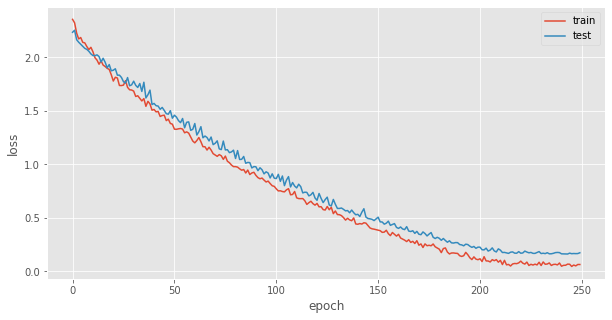

In [94]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [95]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 5.44
Best MAE: 4.25
Average RMSE: 5.59
Average MAE: 4.75


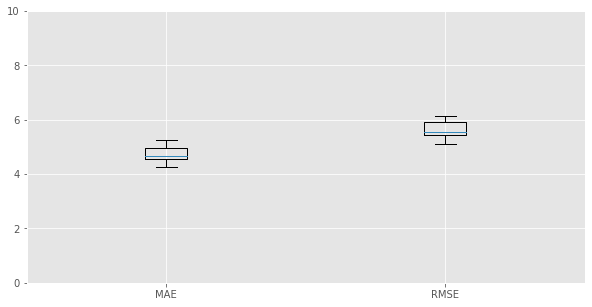

In [96]:
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim(0,10)
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual')

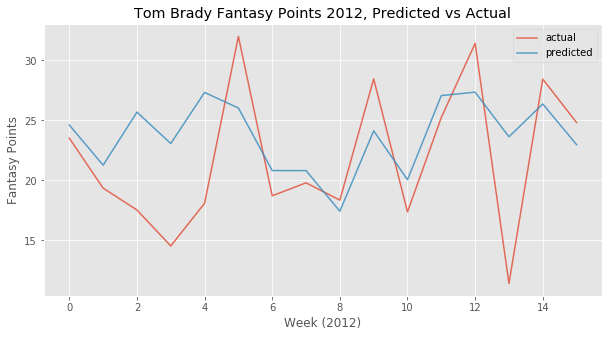

In [97]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual')

##### Iterative Training

In [9]:
# Remake training and test sets for iterative training
window = 5
X, y = build_lstm_data(brady, window)
X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [10]:
%%time
# Rebuild network for iterative training - stateful model with one batch
n_loops = 10
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(100, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), return_sequences=True, bias_regularizer=L1L2(0.01,0.01), stateful=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit network
    n_iters = 250
    for k in range(n_iters):
        t0 = time.time()
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
        print('Epoch {}/{}'.format(k+1, n_iters))
        print('{:.2f}s'.format(time.time()-t0))
        model.reset_states()   
        
                
    # Make predictions for test set
    preds = []
    for j in range(len(y_test)):
        X_test_formatted = X_test[j].reshape(1, X_test[j].shape[0], X_test[j].shape[1])
        preds.append(model.predict(X_test_formatted)[0])
        X_train_upd = np.append(X_train, X_test_formatted, axis=0)
        y_train_upd = np.append(y_train, y_test[j])
        model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()    

    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = model
        best_preds = preds_inv
        
    gc.collect()
             

Epoch 1/250
2.15s
Epoch 2/250
0.18s
Epoch 3/250
0.17s
Epoch 4/250
0.18s
Epoch 5/250
0.16s
Epoch 6/250
0.13s
Epoch 7/250
0.14s
Epoch 8/250
0.14s
Epoch 9/250
0.14s
Epoch 10/250
0.15s
Epoch 11/250
0.15s
Epoch 12/250
0.15s
Epoch 13/250
0.16s
Epoch 14/250
0.16s
Epoch 15/250
0.15s
Epoch 16/250
0.12s
Epoch 17/250
0.13s
Epoch 18/250
0.14s
Epoch 19/250
0.15s
Epoch 20/250
0.18s
Epoch 21/250
0.14s
Epoch 22/250
0.19s
Epoch 23/250
0.22s
Epoch 24/250
0.14s
Epoch 25/250
0.12s
Epoch 26/250
0.19s
Epoch 27/250
0.16s
Epoch 28/250
0.15s
Epoch 29/250
0.12s
Epoch 30/250
0.16s
Epoch 31/250
0.16s
Epoch 32/250
0.14s
Epoch 33/250
0.12s
Epoch 34/250
0.13s
Epoch 35/250
0.17s
Epoch 36/250
0.19s
Epoch 37/250
0.14s
Epoch 38/250
0.17s
Epoch 39/250
0.18s
Epoch 40/250
0.15s
Epoch 41/250
0.13s
Epoch 42/250
0.14s
Epoch 43/250
0.13s
Epoch 44/250
0.16s
Epoch 45/250
0.16s
Epoch 46/250
0.17s
Epoch 47/250
0.18s
Epoch 48/250
0.19s
Epoch 49/250
0.17s
Epoch 50/250
0.13s
Epoch 51/250
0.12s
Epoch 52/250
0.13s
Epoch 53/250
0.13s
Ep

Epoch 173/250
0.13s
Epoch 174/250
0.13s
Epoch 175/250
0.12s
Epoch 176/250
0.19s
Epoch 177/250
0.19s
Epoch 178/250
0.14s
Epoch 179/250
0.13s
Epoch 180/250
0.13s
Epoch 181/250
0.15s
Epoch 182/250
0.14s
Epoch 183/250
0.13s
Epoch 184/250
0.15s
Epoch 185/250
0.15s
Epoch 186/250
0.14s
Epoch 187/250
0.13s
Epoch 188/250
0.14s
Epoch 189/250
0.13s
Epoch 190/250
0.14s
Epoch 191/250
0.12s
Epoch 192/250
0.12s
Epoch 193/250
0.13s
Epoch 194/250
0.12s
Epoch 195/250
0.13s
Epoch 196/250
0.12s
Epoch 197/250
0.12s
Epoch 198/250
0.12s
Epoch 199/250
0.13s
Epoch 200/250
0.14s
Epoch 201/250
0.14s
Epoch 202/250
0.13s
Epoch 203/250
0.14s
Epoch 204/250
0.15s
Epoch 205/250
0.14s
Epoch 206/250
0.14s
Epoch 207/250
0.12s
Epoch 208/250
0.14s
Epoch 209/250
0.12s
Epoch 210/250
0.13s
Epoch 211/250
0.12s
Epoch 212/250
0.12s
Epoch 213/250
0.12s
Epoch 214/250
0.12s
Epoch 215/250
0.15s
Epoch 216/250
0.14s
Epoch 217/250
0.12s
Epoch 218/250
0.14s
Epoch 219/250
0.15s
Epoch 220/250
0.14s
Epoch 221/250
0.15s
Epoch 222/250
0.13s


Epoch 95/250
0.11s
Epoch 96/250
0.12s
Epoch 97/250
0.15s
Epoch 98/250
0.12s
Epoch 99/250
0.09s
Epoch 100/250
0.09s
Epoch 101/250
0.09s
Epoch 102/250
0.11s
Epoch 103/250
0.09s
Epoch 104/250
0.09s
Epoch 105/250
0.11s
Epoch 106/250
0.10s
Epoch 107/250
0.11s
Epoch 108/250
0.11s
Epoch 109/250
0.10s
Epoch 110/250
0.09s
Epoch 111/250
0.10s
Epoch 112/250
0.11s
Epoch 113/250
0.12s
Epoch 114/250
0.15s
Epoch 115/250
0.12s
Epoch 116/250
0.10s
Epoch 117/250
0.11s
Epoch 118/250
0.12s
Epoch 119/250
0.10s
Epoch 120/250
0.16s
Epoch 121/250
0.15s
Epoch 122/250
0.12s
Epoch 123/250
0.10s
Epoch 124/250
0.11s
Epoch 125/250
0.11s
Epoch 126/250
0.13s
Epoch 127/250
0.13s
Epoch 128/250
0.12s
Epoch 129/250
0.11s
Epoch 130/250
0.12s
Epoch 131/250
0.12s
Epoch 132/250
0.13s
Epoch 133/250
0.12s
Epoch 134/250
0.11s
Epoch 135/250
0.13s
Epoch 136/250
0.14s
Epoch 137/250
0.13s
Epoch 138/250
0.12s
Epoch 139/250
0.12s
Epoch 140/250
0.15s
Epoch 141/250
0.15s
Epoch 142/250
0.15s
Epoch 143/250
0.13s
Epoch 144/250
0.10s
Epoch

Epoch 13/250
0.15s
Epoch 14/250
0.14s
Epoch 15/250
0.14s
Epoch 16/250
0.14s
Epoch 17/250
0.14s
Epoch 18/250
0.14s
Epoch 19/250
0.15s
Epoch 20/250
0.14s
Epoch 21/250
0.15s
Epoch 22/250
0.15s
Epoch 23/250
0.14s
Epoch 24/250
0.15s
Epoch 25/250
0.14s
Epoch 26/250
0.14s
Epoch 27/250
0.14s
Epoch 28/250
0.15s
Epoch 29/250
0.15s
Epoch 30/250
0.15s
Epoch 31/250
0.14s
Epoch 32/250
0.14s
Epoch 33/250
0.14s
Epoch 34/250
0.14s
Epoch 35/250
0.15s
Epoch 36/250
0.14s
Epoch 37/250
0.15s
Epoch 38/250
0.14s
Epoch 39/250
0.14s
Epoch 40/250
0.14s
Epoch 41/250
0.14s
Epoch 42/250
0.14s
Epoch 43/250
0.14s
Epoch 44/250
0.15s
Epoch 45/250
0.20s
Epoch 46/250
0.17s
Epoch 47/250
0.16s
Epoch 48/250
0.15s
Epoch 49/250
0.15s
Epoch 50/250
0.15s
Epoch 51/250
0.16s
Epoch 52/250
0.14s
Epoch 53/250
0.15s
Epoch 54/250
0.14s
Epoch 55/250
0.15s
Epoch 56/250
0.16s
Epoch 57/250
0.15s
Epoch 58/250
0.14s
Epoch 59/250
0.14s
Epoch 60/250
0.14s
Epoch 61/250
0.15s
Epoch 62/250
0.14s
Epoch 63/250
0.15s
Epoch 64/250
0.17s
Epoch 65/250

Epoch 185/250
0.10s
Epoch 186/250
0.10s
Epoch 187/250
0.10s
Epoch 188/250
0.10s
Epoch 189/250
0.11s
Epoch 190/250
0.13s
Epoch 191/250
0.10s
Epoch 192/250
0.10s
Epoch 193/250
0.10s
Epoch 194/250
0.11s
Epoch 195/250
0.18s
Epoch 196/250
0.15s
Epoch 197/250
0.10s
Epoch 198/250
0.10s
Epoch 199/250
0.10s
Epoch 200/250
0.10s
Epoch 201/250
0.09s
Epoch 202/250
0.09s
Epoch 203/250
0.10s
Epoch 204/250
0.10s
Epoch 205/250
0.10s
Epoch 206/250
0.10s
Epoch 207/250
0.10s
Epoch 208/250
0.09s
Epoch 209/250
0.10s
Epoch 210/250
0.10s
Epoch 211/250
0.11s
Epoch 212/250
0.13s
Epoch 213/250
0.13s
Epoch 214/250
0.11s
Epoch 215/250
0.11s
Epoch 216/250
0.10s
Epoch 217/250
0.13s
Epoch 218/250
0.11s
Epoch 219/250
0.11s
Epoch 220/250
0.12s
Epoch 221/250
0.13s
Epoch 222/250
0.11s
Epoch 223/250
0.11s
Epoch 224/250
0.12s
Epoch 225/250
0.11s
Epoch 226/250
0.09s
Epoch 227/250
0.10s
Epoch 228/250
0.10s
Epoch 229/250
0.10s
Epoch 230/250
0.10s
Epoch 231/250
0.10s
Epoch 232/250
0.10s
Epoch 233/250
0.09s
Epoch 234/250
0.10s


Epoch 106/250
0.11s
Epoch 107/250
0.10s
Epoch 108/250
0.10s
Epoch 109/250
0.10s
Epoch 110/250
0.10s
Epoch 111/250
0.10s
Epoch 112/250
0.10s
Epoch 113/250
0.10s
Epoch 114/250
0.10s
Epoch 115/250
0.10s
Epoch 116/250
0.15s
Epoch 117/250
0.11s
Epoch 118/250
0.11s
Epoch 119/250
0.10s
Epoch 120/250
0.10s
Epoch 121/250
0.10s
Epoch 122/250
0.10s
Epoch 123/250
0.10s
Epoch 124/250
0.10s
Epoch 125/250
0.10s
Epoch 126/250
0.10s
Epoch 127/250
0.10s
Epoch 128/250
0.09s
Epoch 129/250
0.09s
Epoch 130/250
0.10s
Epoch 131/250
0.10s
Epoch 132/250
0.10s
Epoch 133/250
0.11s
Epoch 134/250
0.10s
Epoch 135/250
0.09s
Epoch 136/250
0.09s
Epoch 137/250
0.09s
Epoch 138/250
0.09s
Epoch 139/250
0.10s
Epoch 140/250
0.09s
Epoch 141/250
0.09s
Epoch 142/250
0.10s
Epoch 143/250
0.09s
Epoch 144/250
0.10s
Epoch 145/250
0.10s
Epoch 146/250
0.10s
Epoch 147/250
0.10s
Epoch 148/250
0.10s
Epoch 149/250
0.10s
Epoch 150/250
0.09s
Epoch 151/250
0.10s
Epoch 152/250
0.09s
Epoch 153/250
0.10s
Epoch 154/250
0.10s
Epoch 155/250
0.10s


In [11]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 5.73
Best MAE: 4.71
Average RMSE: 6.06
Average MAE: 5.13


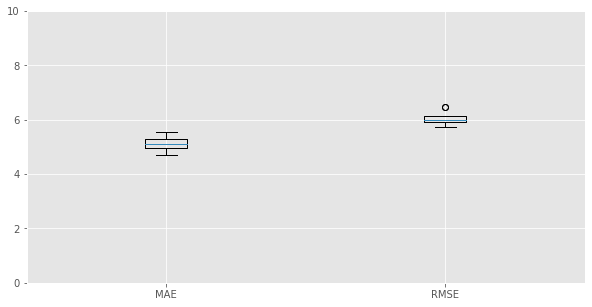

In [12]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

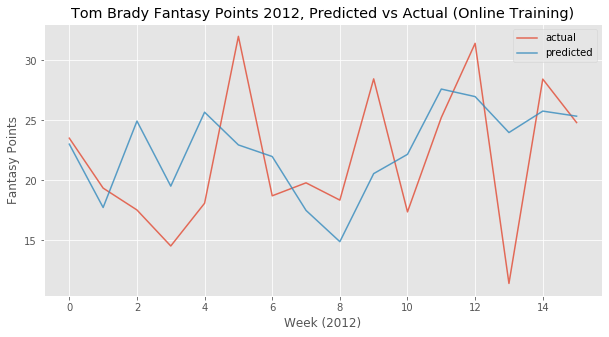

In [13]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('Tom Brady Fantasy Points 2012, Predicted vs Actual (Online Training)')

## LeSean McCoy

In [9]:
# Read in data
mccoy = pd.read_csv('../data/data_final/final/features_raw/mccoy.csv')
mccoy = mccoy.loc[:, features]
mccoy['date'] = pd.to_datetime(mccoy['date'])
mccoy = replace_nans_mean(mccoy, split_date)

In [10]:
# Train + test set indices
mccoy_played_only = mccoy.loc[mccoy['player_played']==1].copy().reset_index(drop=True)
train_idx = mccoy_played_only.loc[mccoy['date']<split_date].index.values
test_idx = mccoy_played_only.loc[mccoy_played_only['date']>split_date].index.values

# Scale Features
mccoy.drop('date', axis=1, inplace=True)
scaler = MinMaxScaler()
scaler.fit(mccoy)
mccoy = scaler.transform(mccoy)

# Train + test sets
train, test = mccoy[train_idx], mccoy[test_idx]

In [11]:
# Create train and test sets
window = 2

X, y = build_lstm_data(mccoy, window)
X = X[y!=0] # Keep games not played for time series, but do not make predictions
y = y[y!=0]

X_train, y_train = X[(train_idx-window)[window:]], y[(train_idx-window)[window:]]
X_test, y_test = X[(test_idx-window)], y[(test_idx-window)]

In [12]:
# Invert scaling of y for testing comparison
y_inv = np.concatenate((y_test.reshape(len(y_test),1), test[:,1:]), axis=1)
y_inv = scaler.inverse_transform(y_inv)
y_inv = y_inv[:,0]

In [142]:
%%time
# Build networks. Loop n times to deal with ranodmness.
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(.3))
    model.add(LSTM(20))
    model.add(Dropout(.3))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    
    # Fit network
    lstm_model = model.fit(X_train, y_train, epochs=20, batch_size=5, validation_data = (X_test, y_test), verbose=2, shuffle=False)
    
    # Make predictions for test set
    preds = model.predict(X_test)
    
    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = lstm_model
        best_preds = preds_inv
        
    gc.collect()


Train on 28 samples, validate on 11 samples
Epoch 1/20
 - 1s - loss: 0.4928 - val_loss: 0.2817
Epoch 2/20
 - 0s - loss: 0.3883 - val_loss: 0.1668
Epoch 3/20
 - 0s - loss: 0.2481 - val_loss: 0.0914
Epoch 4/20
 - 0s - loss: 0.2104 - val_loss: 0.1317
Epoch 5/20
 - 0s - loss: 0.2213 - val_loss: 0.1923
Epoch 6/20
 - 0s - loss: 0.2196 - val_loss: 0.1904
Epoch 7/20
 - 0s - loss: 0.2032 - val_loss: 0.1482
Epoch 8/20
 - 0s - loss: 0.1936 - val_loss: 0.1072
Epoch 9/20
 - 0s - loss: 0.2408 - val_loss: 0.0955
Epoch 10/20
 - 0s - loss: 0.2036 - val_loss: 0.1004
Epoch 11/20
 - 0s - loss: 0.2299 - val_loss: 0.1181
Epoch 12/20
 - 0s - loss: 0.1931 - val_loss: 0.1174
Epoch 13/20
 - 0s - loss: 0.1813 - val_loss: 0.1340
Epoch 14/20
 - 0s - loss: 0.1865 - val_loss: 0.1393
Epoch 15/20
 - 0s - loss: 0.2030 - val_loss: 0.1322
Epoch 16/20
 - 0s - loss: 0.1950 - val_loss: 0.1245
Epoch 17/20
 - 0s - loss: 0.1812 - val_loss: 0.1270
Epoch 18/20
 - 0s - loss: 0.1950 - val_loss: 0.1319
Epoch 19/20
 - 0s - loss: 0.1

 - 0s - loss: 0.2237 - val_loss: 0.1148
Epoch 14/20
 - 0s - loss: 0.1972 - val_loss: 0.1245
Epoch 15/20
 - 0s - loss: 0.1832 - val_loss: 0.1321
Epoch 16/20
 - 0s - loss: 0.1851 - val_loss: 0.1391
Epoch 17/20
 - 0s - loss: 0.1776 - val_loss: 0.1567
Epoch 18/20
 - 0s - loss: 0.1854 - val_loss: 0.1560
Epoch 19/20
 - 0s - loss: 0.1917 - val_loss: 0.1510
Epoch 20/20
 - 0s - loss: 0.2010 - val_loss: 0.1253
Train on 28 samples, validate on 11 samples
Epoch 1/20
 - 1s - loss: 0.5030 - val_loss: 0.2843
Epoch 2/20
 - 0s - loss: 0.3832 - val_loss: 0.1466
Epoch 3/20
 - 0s - loss: 0.2650 - val_loss: 0.0752
Epoch 4/20
 - 0s - loss: 0.1826 - val_loss: 0.1609
Epoch 5/20
 - 0s - loss: 0.1910 - val_loss: 0.2221
Epoch 6/20
 - 0s - loss: 0.2614 - val_loss: 0.2232
Epoch 7/20
 - 0s - loss: 0.2206 - val_loss: 0.1665
Epoch 8/20
 - 0s - loss: 0.1869 - val_loss: 0.1217
Epoch 9/20
 - 0s - loss: 0.1768 - val_loss: 0.1047
Epoch 10/20
 - 0s - loss: 0.1998 - val_loss: 0.1114
Epoch 11/20
 - 0s - loss: 0.1940 - val_lo

Epoch 6/20
 - 0s - loss: 0.2027 - val_loss: 0.1989
Epoch 7/20
 - 0s - loss: 0.2400 - val_loss: 0.2024
Epoch 8/20
 - 0s - loss: 0.1851 - val_loss: 0.2042
Epoch 9/20
 - 0s - loss: 0.1823 - val_loss: 0.2189
Epoch 10/20
 - 0s - loss: 0.2180 - val_loss: 0.2028
Epoch 11/20
 - 0s - loss: 0.1873 - val_loss: 0.1794
Epoch 12/20
 - 0s - loss: 0.2124 - val_loss: 0.1568
Epoch 13/20
 - 0s - loss: 0.1785 - val_loss: 0.1583
Epoch 14/20
 - 0s - loss: 0.1656 - val_loss: 0.1893
Epoch 15/20
 - 0s - loss: 0.1947 - val_loss: 0.2165
Epoch 16/20
 - 0s - loss: 0.2145 - val_loss: 0.2332
Epoch 17/20
 - 0s - loss: 0.2011 - val_loss: 0.2072
Epoch 18/20
 - 0s - loss: 0.2164 - val_loss: 0.1846
Epoch 19/20
 - 0s - loss: 0.2001 - val_loss: 0.1769
Epoch 20/20
 - 0s - loss: 0.1651 - val_loss: 0.1579
Train on 28 samples, validate on 11 samples
Epoch 1/20
 - 1s - loss: 0.4419 - val_loss: 0.2073
Epoch 2/20
 - 0s - loss: 0.3179 - val_loss: 0.0958
Epoch 3/20
 - 0s - loss: 0.2334 - val_loss: 0.1121
Epoch 4/20
 - 0s - loss: 0.

Epoch 19/20
 - 0s - loss: 0.1945 - val_loss: 0.1773
Epoch 20/20
 - 0s - loss: 0.1806 - val_loss: 0.1703
Train on 28 samples, validate on 11 samples
Epoch 1/20
 - 1s - loss: 0.4417 - val_loss: 0.1895
Epoch 2/20
 - 0s - loss: 0.3285 - val_loss: 0.0861
Epoch 3/20
 - 0s - loss: 0.2113 - val_loss: 0.1463
Epoch 4/20
 - 0s - loss: 0.2031 - val_loss: 0.2286
Epoch 5/20
 - 0s - loss: 0.2121 - val_loss: 0.2702
Epoch 6/20
 - 0s - loss: 0.2041 - val_loss: 0.2483
Epoch 7/20
 - 0s - loss: 0.2403 - val_loss: 0.2019
Epoch 8/20
 - 0s - loss: 0.1946 - val_loss: 0.1806
Epoch 9/20
 - 0s - loss: 0.1925 - val_loss: 0.1762
Epoch 10/20
 - 0s - loss: 0.2105 - val_loss: 0.1725
Epoch 11/20
 - 0s - loss: 0.1689 - val_loss: 0.1829
Epoch 12/20
 - 0s - loss: 0.2007 - val_loss: 0.1722
Epoch 13/20
 - 0s - loss: 0.2048 - val_loss: 0.1692
Epoch 14/20
 - 0s - loss: 0.1636 - val_loss: 0.1869
Epoch 15/20
 - 0s - loss: 0.2042 - val_loss: 0.1905
Epoch 16/20
 - 0s - loss: 0.1869 - val_loss: 0.1852
Epoch 17/20
 - 0s - loss: 0.1

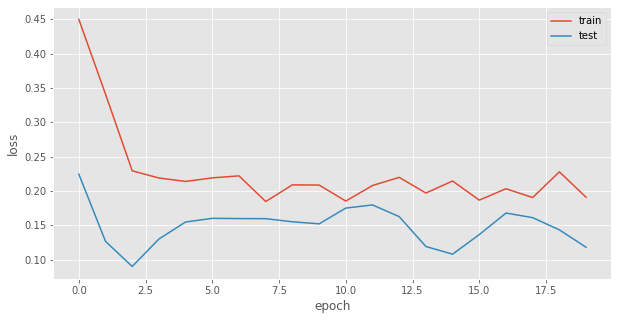

In [143]:
# Plot loss curve for best model
plt.rcParams['figure.figsize'] = (10, 5)

plt.plot(best_model.history['loss'], label='train')
plt.plot(best_model.history['val_loss'], label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [144]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 4.62
Best MAE: 3.77
Average RMSE: 5.45
Average MAE: 4.84


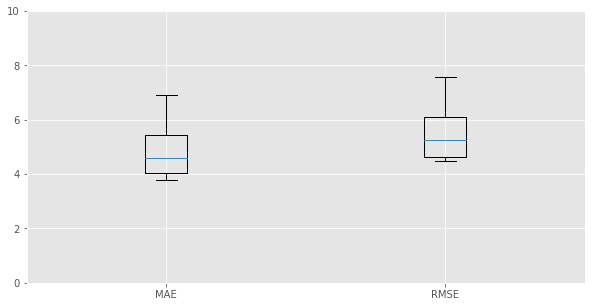

In [147]:
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

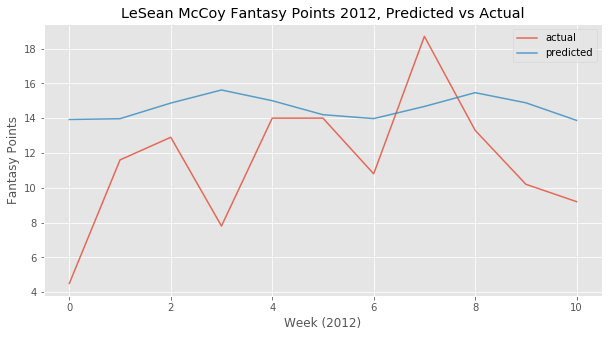

In [146]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

#### Online Training

In [13]:
%%time
# Rebuild network for iterative training - stateful model with one batch
n_loops = 25
rmses, maes = [], []
best_rmse, best_mae = 100, 100
best_model = None
best_preds = []

for i in range(0, n_loops):
    model = Sequential()
    model.add(LSTM(30, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), return_sequences=True, stateful=True))
    model.add(Dropout(0.3))
    model.add(LSTM(20))
    model.add(Dropout(0.3))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    
    # Fit network
    n_iters = 20
    for k in range(n_iters):
        t0 = time.time()
        model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=0, shuffle=False)
        print('Epoch {}/{}'.format(k+1, n_iters))
        print('{:.2f}s'.format(time.time()-t0))
        model.reset_states()   
        
                
    # Make predictions for test set
    preds = []
    for j in range(len(y_test)):
        X_test_formatted = X_test[j].reshape(1, X_test[j].shape[0], X_test[j].shape[1])
        preds.append(model.predict(X_test_formatted)[0])
        X_train_upd = np.append(X_train, X_test_formatted, axis=0)
        y_train_upd = np.append(y_train, y_test[j])
        model.fit(X_train_upd, y_train_upd, epochs=10, batch_size=1, verbose=0, shuffle=False)
        model.reset_states()    

    # Invert scaling for preds
    preds_inv = np.concatenate((preds, test[:,1:]), axis=1)
    preds_inv = scaler.inverse_transform(preds_inv)
    preds_inv = preds_inv[:,0]
    
    # Calculate RMSE and MAE
    rmses.append(np.sqrt(mean_squared_error(y_inv, preds_inv)))
    maes.append(mean_absolute_error(y_inv, preds_inv))
    
    if maes[i] < best_mae:
        best_rmse = rmses[i]
        best_mae = maes[i]
        best_model = model
        best_preds = preds_inv
        
    gc.collect()
             

Epoch 1/20
1.97s
Epoch 2/20
0.08s
Epoch 3/20
0.08s
Epoch 4/20
0.08s
Epoch 5/20
0.10s
Epoch 6/20
0.08s
Epoch 7/20
0.09s
Epoch 8/20
0.08s
Epoch 9/20
0.07s
Epoch 10/20
0.08s
Epoch 11/20
0.10s
Epoch 12/20
0.07s
Epoch 13/20
0.10s
Epoch 14/20
0.09s
Epoch 15/20
0.08s
Epoch 16/20
0.07s
Epoch 17/20
0.08s
Epoch 18/20
0.07s
Epoch 19/20
0.06s
Epoch 20/20
0.08s
Epoch 1/20
2.19s
Epoch 2/20
0.07s
Epoch 3/20
0.09s
Epoch 4/20
0.11s
Epoch 5/20
0.11s
Epoch 6/20
0.10s
Epoch 7/20
0.08s
Epoch 8/20
0.07s
Epoch 9/20
0.07s
Epoch 10/20
0.07s
Epoch 11/20
0.06s
Epoch 12/20
0.06s
Epoch 13/20
0.08s
Epoch 14/20
0.08s
Epoch 15/20
0.07s
Epoch 16/20
0.09s
Epoch 17/20
0.07s
Epoch 18/20
0.07s
Epoch 19/20
0.07s
Epoch 20/20
0.07s
Epoch 1/20
2.23s
Epoch 2/20
0.07s
Epoch 3/20
0.07s
Epoch 4/20
0.08s
Epoch 5/20
0.10s
Epoch 6/20
0.07s
Epoch 7/20
0.07s
Epoch 8/20
0.06s
Epoch 9/20
0.06s
Epoch 10/20
0.07s
Epoch 11/20
0.07s
Epoch 12/20
0.06s
Epoch 13/20
0.06s
Epoch 14/20
0.06s
Epoch 15/20
0.07s
Epoch 16/20
0.06s
Epoch 17/20
0.06s
E

Epoch 10/20
0.06s
Epoch 11/20
0.07s
Epoch 12/20
0.06s
Epoch 13/20
0.06s
Epoch 14/20
0.07s
Epoch 15/20
0.06s
Epoch 16/20
0.06s
Epoch 17/20
0.06s
Epoch 18/20
0.07s
Epoch 19/20
0.06s
Epoch 20/20
0.07s
Epoch 1/20
7.76s
Epoch 2/20
0.08s
Epoch 3/20
0.07s
Epoch 4/20
0.07s
Epoch 5/20
0.08s
Epoch 6/20
0.07s
Epoch 7/20
0.07s
Epoch 8/20
0.07s
Epoch 9/20
0.06s
Epoch 10/20
0.06s
Epoch 11/20
0.07s
Epoch 12/20
0.06s
Epoch 13/20
0.06s
Epoch 14/20
0.06s
Epoch 15/20
0.07s
Epoch 16/20
0.06s
Epoch 17/20
0.06s
Epoch 18/20
0.06s
Epoch 19/20
0.07s
Epoch 20/20
0.06s
CPU times: user 9min, sys: 1min 16s, total: 10min 17s
Wall time: 5min 46s


In [14]:
# Print RMSES and MAES
print('Best RMSE: {:.2f}'.format(best_rmse))
print('Best MAE: {:.2f}'.format(best_mae))
print('Average RMSE: {:.2f}'.format(np.mean(rmses)))
print('Average MAE: {:.2f}'.format(np.mean(maes)))

Best RMSE: 3.20
Best MAE: 2.72
Average RMSE: 4.62
Average MAE: 3.80


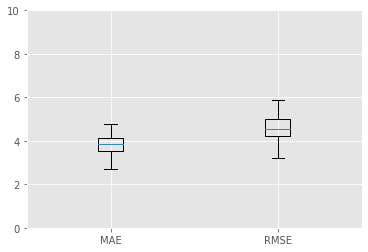

In [15]:
plt.boxplot([maes, rmses])
plt.xticks([1,2],['MAE', 'RMSE'])
plt.ylim((0,10))
plt.show()

Text(0.5, 1.0, 'LeSean McCoy Fantasy Points 2012, Predicted vs Actual')

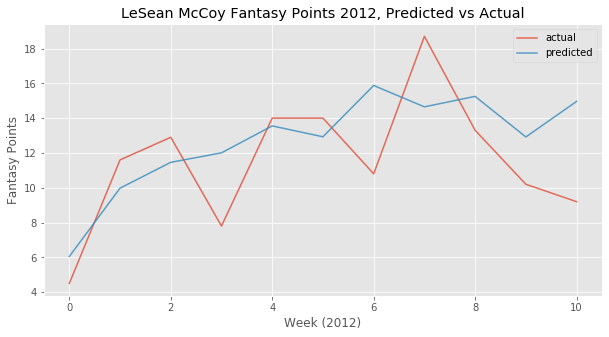

In [16]:
plt.rcParams['figure.figsize'] = (10, 5)
fig, ax = plt.subplots()
plot1 = ax.plot(y_inv, alpha = 0.8, label='actual')
plot1 = ax.plot(best_preds, alpha = 0.8, label='predicted')
ax.legend()
plt.xlabel('Week (2012)')
plt.ylabel('Fantasy Points')
plt.title('LeSean McCoy Fantasy Points 2012, Predicted vs Actual')